## Data Exploration (ML50-2023) - Duarte

### __Importing libraries__

In [1]:
import pandas as pd
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

# -------------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Read data
test = pd.read_csv("test.csv", index_col='encounter_id')
train = pd.read_csv("train.csv", index_col='encounter_id')
icd_9 = pd.read_csv("icd9_codes.txt", sep=',', encoding='ISO-8859-1', index_col=0)
icd_9['3 digit code'] = icd_9.index.str[:3]
icd_9.set_index('3 digit code', inplace=True)
# Delete duplicates in the index
icd_9 = icd_9[~icd_9.index.duplicated(keep='first')]

test_ids = test.index
train_ids = train.index

# Data will have to be treated as a whole, so we will concatenate the test and training data
# data = pd.concat([train, test], axis=0)

# Change the target variable to 0 and 1
#data['readmitted_binary'] = data['readmitted_binary'].map({'No': 0, 'Yes': 1})
train['readmitted_binary'] = train['readmitted_binary'].map({'No': 0, 'Yes': 1})

In [3]:
pd.set_option('display.max_columns', None)

### __I. Data Exploration and Selection__ -  Binary Classification
- Explore the data
- Check for non-varying features 
- Intuition-based feature selection
- Changing variable names for simplicity

In [4]:
train.sort_values(by='encounter_id', inplace=True)
train.head(5).T

encounter_id,100000,100020,100022,100076,100078
country,USA,USA,USA,USA,USA
patient_id,93450780,23711949,5010480,24744411,23188977
race,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Male,Female,Female,Female,Female
age,[60-70),[40-50),[50-60),[90-100),[60-70)
weight,?,?,?,?,?
payer_code,CP,HM,UN,MC,MC
outpatient_visits_in_previous_year,0,0,0,0,0
emergency_visits_in_previous_year,0,0,0,0,0
inpatient_visits_in_previous_year,0,0,0,0,0


In [5]:
train

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,average_pulse_bpm,discharge_disposition,admission_source,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000,USA,93450780,Caucasian,Male,[60-70),?,CP,0,0,0,Emergency,Emergency/Trauma,62,Discharged to home,Emergency Room,3,39,0,4,191,780,250,3,NaN,NaN,No,No,[],1,<30 days
100020,USA,23711949,Caucasian,Female,[40-50),?,HM,0,0,0,Not Available,Family/GeneralPractice,86,Discharged to home,NaN,2,9,0,14,493,250.01,311,5,Norm,NaN,Ch,Yes,['insulin'],0,No
100022,USA,5010480,Caucasian,Female,[50-60),?,UN,0,0,0,Urgent,InternalMedicine,75,Discharged to home,Physician Referral,4,38,2,15,427,401,250,5,NaN,NaN,Ch,Yes,"['metformin', 'glyburide', 'insulin']",1,<30 days
100076,USA,24744411,Caucasian,Female,[90-100),?,MC,0,0,0,Emergency,Family/GeneralPractice,115,Discharged to home,Emergency Room,2,44,0,9,276,599,465,8,NaN,NaN,No,No,[],0,No
100078,USA,23188977,Caucasian,Female,[60-70),?,MC,0,0,0,Urgent,InternalMedicine,70,Discharged to home,Physician Referral,6,37,0,21,486,428,250,7,NaN,NaN,Ch,Yes,"['glimepiride', 'pioglitazone', 'insulin']",0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999940,USA,94147587,Caucasian,Male,[90-100),?,MC,0,0,0,Elective,?,101,Discharged to home,Physician Referral,1,21,1,7,428,511,427,9,NaN,>7,No,No,[],0,No
999953,USA,96923772,Caucasian,Male,[70-80),?,MC,0,0,0,Emergency,?,128,Discharged to home,Physician Referral,1,60,0,10,786,496,440,9,NaN,>7,No,Yes,['pioglitazone'],0,>30 days
999966,USA,88691724,Caucasian,Female,[80-90),?,MC,4,0,1,Emergency,?,86,Discharged/transferred to SNF,Emergency Room,2,28,0,20,486,427,428,9,NaN,NaN,No,Yes,['insulin'],0,>30 days


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71236 entries, 100000 to 999980
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   country                                71236 non-null  object
 1   patient_id                             71236 non-null  int64 
 2   race                                   67682 non-null  object
 3   gender                                 71236 non-null  object
 4   age                                    67679 non-null  object
 5   weight                                 71236 non-null  object
 6   payer_code                             71236 non-null  object
 7   outpatient_visits_in_previous_year     71236 non-null  int64 
 8   emergency_visits_in_previous_year      71236 non-null  int64 
 9   inpatient_visits_in_previous_year      71236 non-null  int64 
 10  admission_type                         67530 non-null  object
 11  medical_s

In [7]:
train.isna().sum()

country                                      0
patient_id                                   0
race                                      3554
gender                                       0
age                                       3557
weight                                       0
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3706
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                     2590
admission_source                          4718
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_diagnosis                          0
additional_di

In [8]:
for col in train:
    print(col,": ", train[col].unique())
    
    if any(train[col]==""):
        print("This columns has empty strings")
    
    print("\n ############################ \n")

country :  ['USA']

 ############################ 

patient_id :  [93450780 23711949  5010480 ... 94147587 96923772 67469157]

 ############################ 

race :  ['Caucasian' nan 'AfricanAmerican' 'Hispanic' '?' 'Asian' 'Other']

 ############################ 

gender :  ['Male' 'Female' 'Unknown/Invalid']

 ############################ 

age :  ['[60-70)' '[40-50)' '[50-60)' '[90-100)' '[70-80)' '[30-40)' '[80-90)'
 nan '[20-30)' '[10-20)' '[0-10)']

 ############################ 

weight :  ['?' '[50-75)' '[75-100)' '[100-125)' '[125-150)' '[25-50)' '[175-200)'
 '[0-25)' '[150-175)' '>200']

 ############################ 

payer_code :  ['CP' 'HM' 'UN' 'MC' 'BC' '?' 'SP' 'MD' 'SI' 'CM' 'DM' 'OG' 'WC' 'CH' 'PO'
 'OT' 'MP' 'FR']

 ############################ 

outpatient_visits_in_previous_year :  [ 0  1  4  2  3  7  5  6  9 10 29  8 13 19 27 15 11 16 18 12 42 21 20 14
 23 38 36 22 24 39 33 17 25 35 26 28 37 34]

 ############################ 

emergency_visits_in_previous_year :


 ############################ 

change_in_meds_during_hospitalization :  ['No' 'Ch']

 ############################ 

prescribed_diabetes_meds :  ['No' 'Yes']

 ############################ 

medication :  ['[]' "['insulin']" "['metformin', 'glyburide', 'insulin']"
 "['glimepiride', 'pioglitazone', 'insulin']" "['glyburide']"
 "['glimepiride', 'insulin']" "['metformin']" "['metformin', 'insulin']"
 "['glipizide', 'insulin']" "['glipizide']" "['glyburide', 'insulin']"
 "['metformin', 'pioglitazone', 'insulin']"
 "['glyburide', 'pioglitazone', 'insulin']" "['acarbose']"
 "['glimepiride']" "['glyburide', 'rosiglitazone']"
 "['metformin', 'glipizide', 'rosiglitazone', 'insulin']"
 "['glipizide', 'pioglitazone', 'insulin']" "['pioglitazone', 'insulin']"
 "['glyburide', 'rosiglitazone', 'insulin']"
 "['rosiglitazone', 'insulin']" "['metformin', 'glipizide']"
 "['glyburide', 'pioglitazone']" "['metformin', 'glyburide']"
 "['pioglitazone']" "['rosiglitazone']"
 "['metformin', 'glyburide', 'pi

In [9]:
train["gender"].value_counts()

Female             38228
Male               33005
Unknown/Invalid        3
Name: gender, dtype: int64

In [10]:
train["race"].value_counts()

Caucasian          50693
AfricanAmerican    12693
?                   1516
Hispanic            1364
Other                995
Asian                421
Name: race, dtype: int64

1. Non varying features

In [11]:
# We can immediately see that there is only one country, USA, so we can drop that non-informative column
train.drop('country', axis=1, inplace=True)

2. Gender is probably not relevant, so let's check for independence between gender and the target variable for both target variables.

In [12]:
# Perform a chi-sq test for independence between the gender and the target variable
pre_contingency = train.groupby('gender')['readmitted_binary'].value_counts()
table = pre_contingency.unstack().drop('Unknown/Invalid', axis=0)

chi2, p, dof, expected = chi2_contingency(table)

# Print if we can reject the null hypothesis
print('p-value: ', round(p,3), '> 0.05' if p > 0.05 else '< 0.05')
if p < 0.05:
    print('We reject the null hypothesis, the variables are dependent')
else:
    print('We cannot reject the null hypothesis, the variables are independent')

p-value:  0.121 > 0.05
We cannot reject the null hypothesis, the variables are independent


In [13]:
# Perform a chi-sq test for independence between the gender and the target variable
pre_contingency_multi = train.groupby('gender')['readmitted_multiclass'].value_counts()
table_multi = pre_contingency.unstack().drop('Unknown/Invalid', axis=0)

chi2, p, dof, expected = chi2_contingency(table_multi)

# Print if we can reject the null hypothesis
print('p-value: ', round(p,3), '> 0.05' if p > 0.05 else '< 0.05')
if p < 0.05:
    print('We reject the null hypothesis, the variables are dependent')
else:
    print('We cannot reject the null hypothesis, the variables are independent')

p-value:  0.121 > 0.05
We cannot reject the null hypothesis, the variables are independent


In [14]:
# We, therefore drop the gender column
gender = train['gender']
train.drop('gender', axis=1, inplace=True)

3. Let's do the same for race.

In [15]:
table = train.groupby('race')['readmitted_binary'].value_counts().unstack()
table = table.drop('?', axis=0)
chi2, p, dof, expected = chi2_contingency(table)

# Print if we can reject the null hypothesis
print('p-value: ', round(p,3), '> 0.05' if p > 0.05 else '< 0.05')
if p < 0.05:
    print('We reject the null hypothesis, the variables are dependent')
else:
    print('We cannot reject the null hypothesis, the variables are independent')

p-value:  0.039 < 0.05
We reject the null hypothesis, the variables are dependent


In [16]:
table = train.groupby('race')['readmitted_multiclass'].value_counts().unstack()
table = table.drop('?', axis=0)
chi2, p, dof, expected = chi2_contingency(table)

# Print if we can reject the null hypothesis
print('p-value: ', round(p,3), '> 0.05' if p > 0.05 else '< 0.05')
if p < 0.05:
    print('We reject the null hypothesis, the variables are dependent')
else:
    print('We cannot reject the null hypothesis, the variables are independent')

p-value:  0.0 < 0.05
We reject the null hypothesis, the variables are dependent


4. Lets change long variable names for simplicity

In [17]:
mapper = {
    'outpatient_visits_in_previous_year': 'outvisits',
    'inpatient_visits_in_previous_year': 'invisits',
    'emergency_visits_in_previous_year': 'emvisits',
    'change_in_meds_during_hospitalization': 'change_meds',
    'prescribed_diabetes_meds': 'diabetes_meds',
    'length_of_stay_in_hospital': 'length_stay',
    'number_of_medications': 'num_meds',
    'primary_diagnosis': 'diag_1',
    'secondary_diagnosis': 'diag_2',
    'additional_diagnosis': 'diag_3',
    'number_diagnoses': 'num_diag',
    'number_lab_tests': 'num_tests',
    'discharge_disposition': 'disposition'
}

train.rename(columns=mapper, inplace=True)

In [18]:
#train.T

### __II. Feature encoding__
- This is the first step for our analysis, as we need to transform the categorical variables/binary into numerical ones. We will use the __LabelEncoder__ from the __sklearn.preprocessing__ library to do so.

- We will also convert intervals to middle values, so we can treat them as numerical variables.

- Medication is not a useful feature as it is, so we will create many new dummy features from it.

0. Diagnosis codes (ICD9) - There are codes with less than 3 digits, so we will add 0 to the codes with only 2 digits, and two 0 to to the codes with one digit.

In [19]:
# Adding a 0 to the codes that have only two digits
train['diag_1'] = train['diag_1'].apply(lambda x: '0' + x if len(x) == 2 else x)
train['diag_1'] = train['diag_1'].apply(lambda x: '00' + x if len(x) == 1 and x!='?' else x)
train['diag_1'] = train['diag_1'].apply(lambda x: x if len(x) == 3 else x[:3])
train['diag_2'] = train['diag_2'].apply(lambda x: '0' + x if len(x) == 2 else x)
train['diag_2'] = train['diag_2'].apply(lambda x: '00' + x if len(x) == 1 and x != '?' else x)
train['diag_2'] = train['diag_2'].apply(lambda x: x if len(x) == 3 else x[:3])
train['diag_3'] = train['diag_3'].apply(lambda x: '0' + x if len(x) == 2 else x)
train['diag_3'] = train['diag_3'].apply(lambda x: '00' + x if len(x) == 1 and x != '?' else x)
train['diag_3'] = train['diag_3'].apply(lambda x: x if len(x) == 3 else x[:3])

1. Encoding the variables - to binary

In [20]:
# Transform the target variable, and two meds features into a binary variable
train['diabetes_meds'] = train['diabetes_meds'].map({'No': 0, 'Yes': 1})
train['change_meds'] = train['change_meds'].map({'No': 0, 'Ch': 1})

2. Encoding the variables - to class

In [21]:
# First we need to convert ? to NaN
# Print which features contain '?'
print('Features with ? : ', train.columns[train.isin(['?']).any()].tolist())

# Replace ? with NaN
train.replace('?', np.nan, inplace=True)

Features with ? :  ['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']


"admission_type" and admission_source contain "Not Available" values, so we will replace them with "NaN"

In [22]:
# Change Nan to Not Available
train['admission_type'] = train['admission_type'].fillna('Not Available')
train['admission_source'] = train['admission_source'].fillna(' Not Available')

In [23]:
# Encode the following variables: race, (gender?), payer_code, admission_type, medical_specialty, discharge_disposition, admission_source
features_to_encode = ['race', 'payer_code', 'admission_type', 'medical_specialty', 'disposition', 'admission_source']
encoder_dict = {features_to_encode[i]: LabelEncoder() for i in range(len(features_to_encode))}
for feature in features_to_encode:
    encoder_dict[feature].fit(train[feature])
    train[feature] = encoder_dict[feature].transform(train[feature].values)
    # Convert the class of Nan to Nan, which is always the last for classes that are not admission_type and admission_source
    if feature not in ['admission_type', 'admission_source']:
        train[feature].replace(encoder_dict[feature].transform(encoder_dict[feature].classes_)[-1], np.nan, inplace=True)
    print(f'{feature} classes: ', dict(zip(encoder_dict[feature].classes_, encoder_dict[feature].transform(encoder_dict[feature].classes_))))

race classes:  {'AfricanAmerican': 0, 'Asian': 1, 'Caucasian': 2, 'Hispanic': 3, 'Other': 4, nan: 5}
payer_code classes:  {'BC': 0, 'CH': 1, 'CM': 2, 'CP': 3, 'DM': 4, 'FR': 5, 'HM': 6, 'MC': 7, 'MD': 8, 'MP': 9, 'OG': 10, 'OT': 11, 'PO': 12, 'SI': 13, 'SP': 14, 'UN': 15, 'WC': 16, nan: 17}
admission_type classes:  {'Elective': 0, 'Emergency': 1, 'Newborn': 2, 'Not Available': 3, 'Not Mapped': 4, 'Trauma Center': 5, 'Urgent': 6}
medical_specialty classes:  {'AllergyandImmunology': 0, 'Anesthesiology': 1, 'Anesthesiology-Pediatric': 2, 'Cardiology': 3, 'Cardiology-Pediatric': 4, 'DCPTEAM': 5, 'Dentistry': 6, 'Emergency/Trauma': 7, 'Endocrinology': 8, 'Endocrinology-Metabolism': 9, 'Family/GeneralPractice': 10, 'Gastroenterology': 11, 'Gynecology': 12, 'Hematology': 13, 'Hematology/Oncology': 14, 'Hospitalist': 15, 'InfectiousDiseases': 16, 'InternalMedicine': 17, 'Nephrology': 18, 'Neurology': 19, 'Neurophysiology': 20, 'Obsterics&Gynecology-GynecologicOnco': 21, 'Obstetrics': 22, 'Obst

3. Transforming age and weight into numerical variables

In [24]:
train['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}, inplace=True)
train['weight'].replace({'[0-25)': 12.5, '[25-50)': 37.5, '[50-75)': 62.5, '[75-100)': 87.5, '[100-125)': 112.5, '[125-150)': 137.5, '[150-175)': 162.5, '[175-200)': 187.5, '>200': 225}, inplace=True)

4. Transforming medication into dummy variables

In [25]:
# Transforming the medication list into many dummy variables
meds = train['medication'].str.get_dummies(sep=',')

# Remove any symbols from the column names
to_remove = ['[', ']', "'", ' ']
for symbol in to_remove:
    meds.columns = meds.columns.str.replace(symbol, '', regex=True)

In [26]:
unique_cols = meds.columns.unique()
new_meds = pd.DataFrame(columns=unique_cols)
for col in unique_cols:
    if type(meds[col]) == pd.Series:
        new_meds[col] = meds[col]
    else:
        new_meds[col] = meds[col].max(axis=1)
meds = new_meds

# Lets delete combinations of drugs
for col in meds.columns.unique():
    if '-' in col:
        meds.drop(col, axis=1, inplace=True)

# Rename the last column to avoid confusion
meds.rename(columns={'' : 'no_meds'}, inplace=True)

meds.head()

,acarbose,chlorpropamide,glimepiride,glipizide,glyburide,insulin,miglitol,nateglinide,pioglitazone,repaglinide,rosiglitazone,tolazamide,tolbutamide,troglitazone,acetohexamide,metformin,no_meds
encounter_id,,,,,,,,,,,,,,,,,
100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100020,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
100022,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
100076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100078,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0


Adding the new features to the dataset

In [27]:
train = pd.concat([train,meds], axis=1)
# Deleting the medication column
train.drop('medication', axis=1, inplace=True)

In [28]:
train

,patient_id,race,age,weight,payer_code,outvisits,emvisits,invisits,admission_type,medical_specialty,average_pulse_bpm,disposition,admission_source,length_stay,num_tests,non_lab_procedures,num_meds,diag_1,diag_2,diag_3,num_diag,glucose_test_result,a1c_test_result,change_meds,diabetes_meds,readmitted_binary,readmitted_multiclass,acarbose,chlorpropamide,glimepiride,glipizide,glyburide,insulin,miglitol,nateglinide,pioglitazone,repaglinide,rosiglitazone,tolazamide,tolbutamide,troglitazone,acetohexamide,metformin,no_meds
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000,93450780,2.0,65.0,NaN,3.0,0,0,0,1,7.0,62,1.0,1,3,39,0,4,191,780,250,3,NaN,NaN,0,0,1,<30 days,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100020,23711949,2.0,45.0,NaN,6.0,0,0,0,3,10.0,86,1.0,3,2,9,0,14,493,250,311,5,Norm,NaN,1,1,0,No,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
100022,5010480,2.0,55.0,NaN,15.0,0,0,0,6,17.0,75,1.0,5,4,38,2,15,427,401,250,5,NaN,NaN,1,1,1,<30 days,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
100076,24744411,2.0,95.0,NaN,7.0,0,0,0,1,10.0,115,1.0,1,2,44,0,9,276,599,465,8,NaN,NaN,0,0,0,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100078,23188977,2.0,65.0,NaN,7.0,0,0,0,6,17.0,70,1.0,5,6,37,0,21,486,428,250,7,NaN,NaN,1,1,0,No,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999940,94147587,2.0,95.0,NaN,7.0,0,0,0,0,NaN,101,1.0,5,1,21,1,7,428,511,427,9,NaN,>7,0,0,0,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
999953,96923772,2.0,75.0,NaN,7.0,0,0,0,1,NaN,128,1.0,5,1,60,0,10,786,496,440,9,NaN,>7,0,1,0,>30 days,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
999966,88691724,2.0,85.0,NaN,7.0,4,0,1,1,NaN,86,3.0,1,2,28,0,20,486,427,428,9,NaN,NaN,0,1,0,>30 days,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### __III. Understanding the data__ - Binary Classification
- For numerical features, let's get the correlation to the target variable and the correlation between the features.
- For other variables, let's get the representation of each class in the target variable.

In [29]:
# Saving a copy 
train_II = train.copy()
numerical_features = ['age', 'weight', 'outvisits', 'emvisits', 'invisits', 'average_pulse_bpm', 'length_stay', 'num_tests', 'non_lab_procedures', 'num_meds', 'num_diag']
binary_features = ['change_meds', 'diabetes_meds', 'no_meds', 'acarbose', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'insulin', 'miglitol', 'nateglinide', 'pioglitazone', 'repaglinide', 'rosiglitazone', 'tolazamide', 'tolbutamide', 'troglitazone', 'acarbose', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'insulin', 'miglitol', 'nateglinide', 'pioglitazone', 'repaglinide', 'rosiglitazone', 'tolazamide', 'tolbutamide', 'troglitazone', 'acetohexamide', 'metformin']
categorical_features = set(train.columns) - set(numerical_features) - set(binary_features) - set(['readmitted_binary', 'readmitted_multiclass', 'patient_id'])

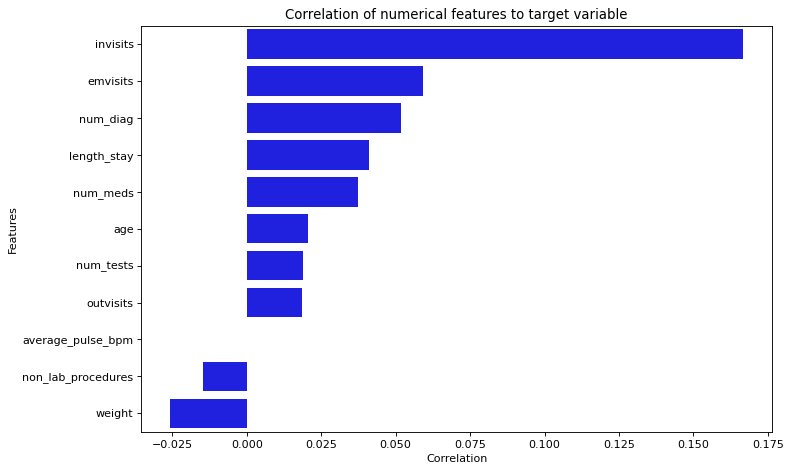

In [30]:
# Lets get the variables correlation to the target variable
correl = train[numerical_features+['readmitted_binary']].corr(method='pearson')['readmitted_binary'].sort_values(ascending=False)
correl.drop('readmitted_binary', inplace=True)

# Lets plot the correlation
plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=correl.values, y=correl.index, color='b')
plt.title('Correlation of numerical features to target variable')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

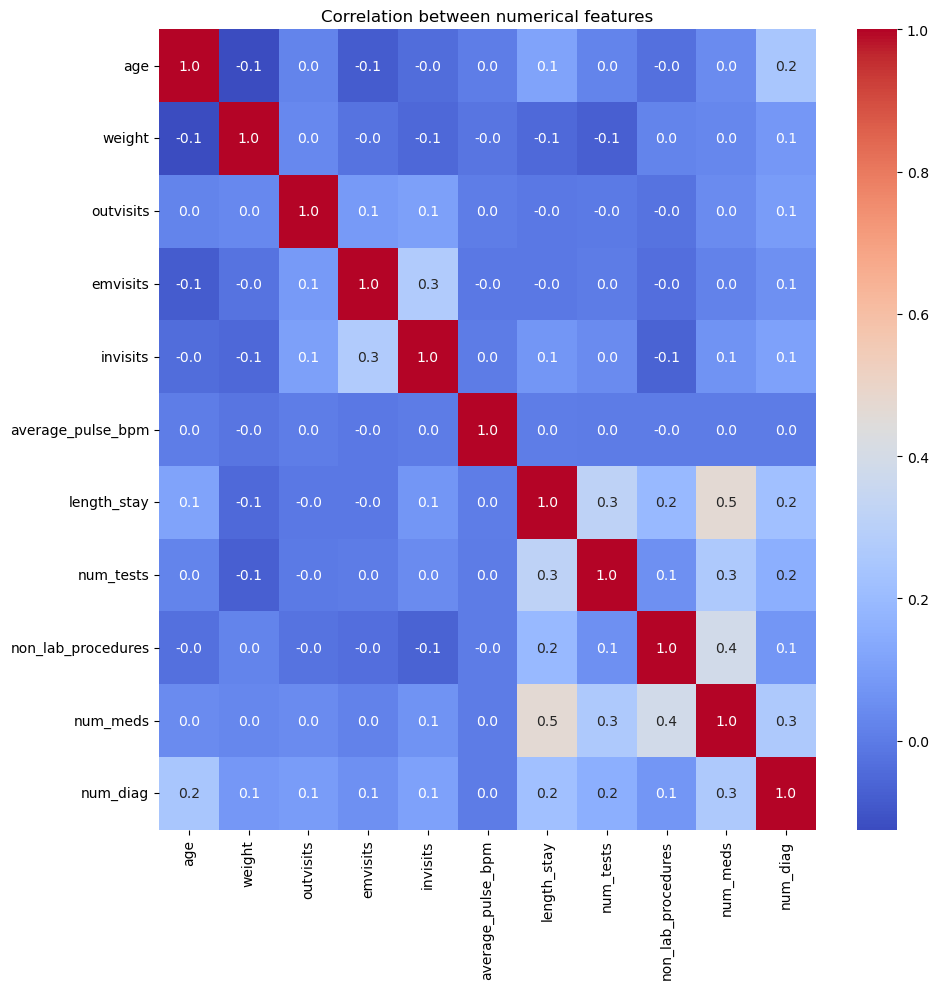

In [31]:
# Lets plot the heatmap of the correlation for the numerical features
plt.figure(figsize=(10,10), dpi=100)
sns.heatmap(train[numerical_features].corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation between numerical features')
plt.tight_layout()
plt.show()

Average pulse (bpm) seems to be completely independent from the target variable, and from the other features. We will drop it.

In [32]:
average_pulse_bpm = train['average_pulse_bpm']
train = train.drop(['average_pulse_bpm'], axis=1)

2. Categorical features (except for diagnosis)

In [33]:
categorical_features

{'a1c_test_result',
 'admission_source',
 'admission_type',
 'diag_1',
 'diag_2',
 'diag_3',
 'disposition',
 'glucose_test_result',
 'medical_specialty',
 'payer_code',
 'race'}

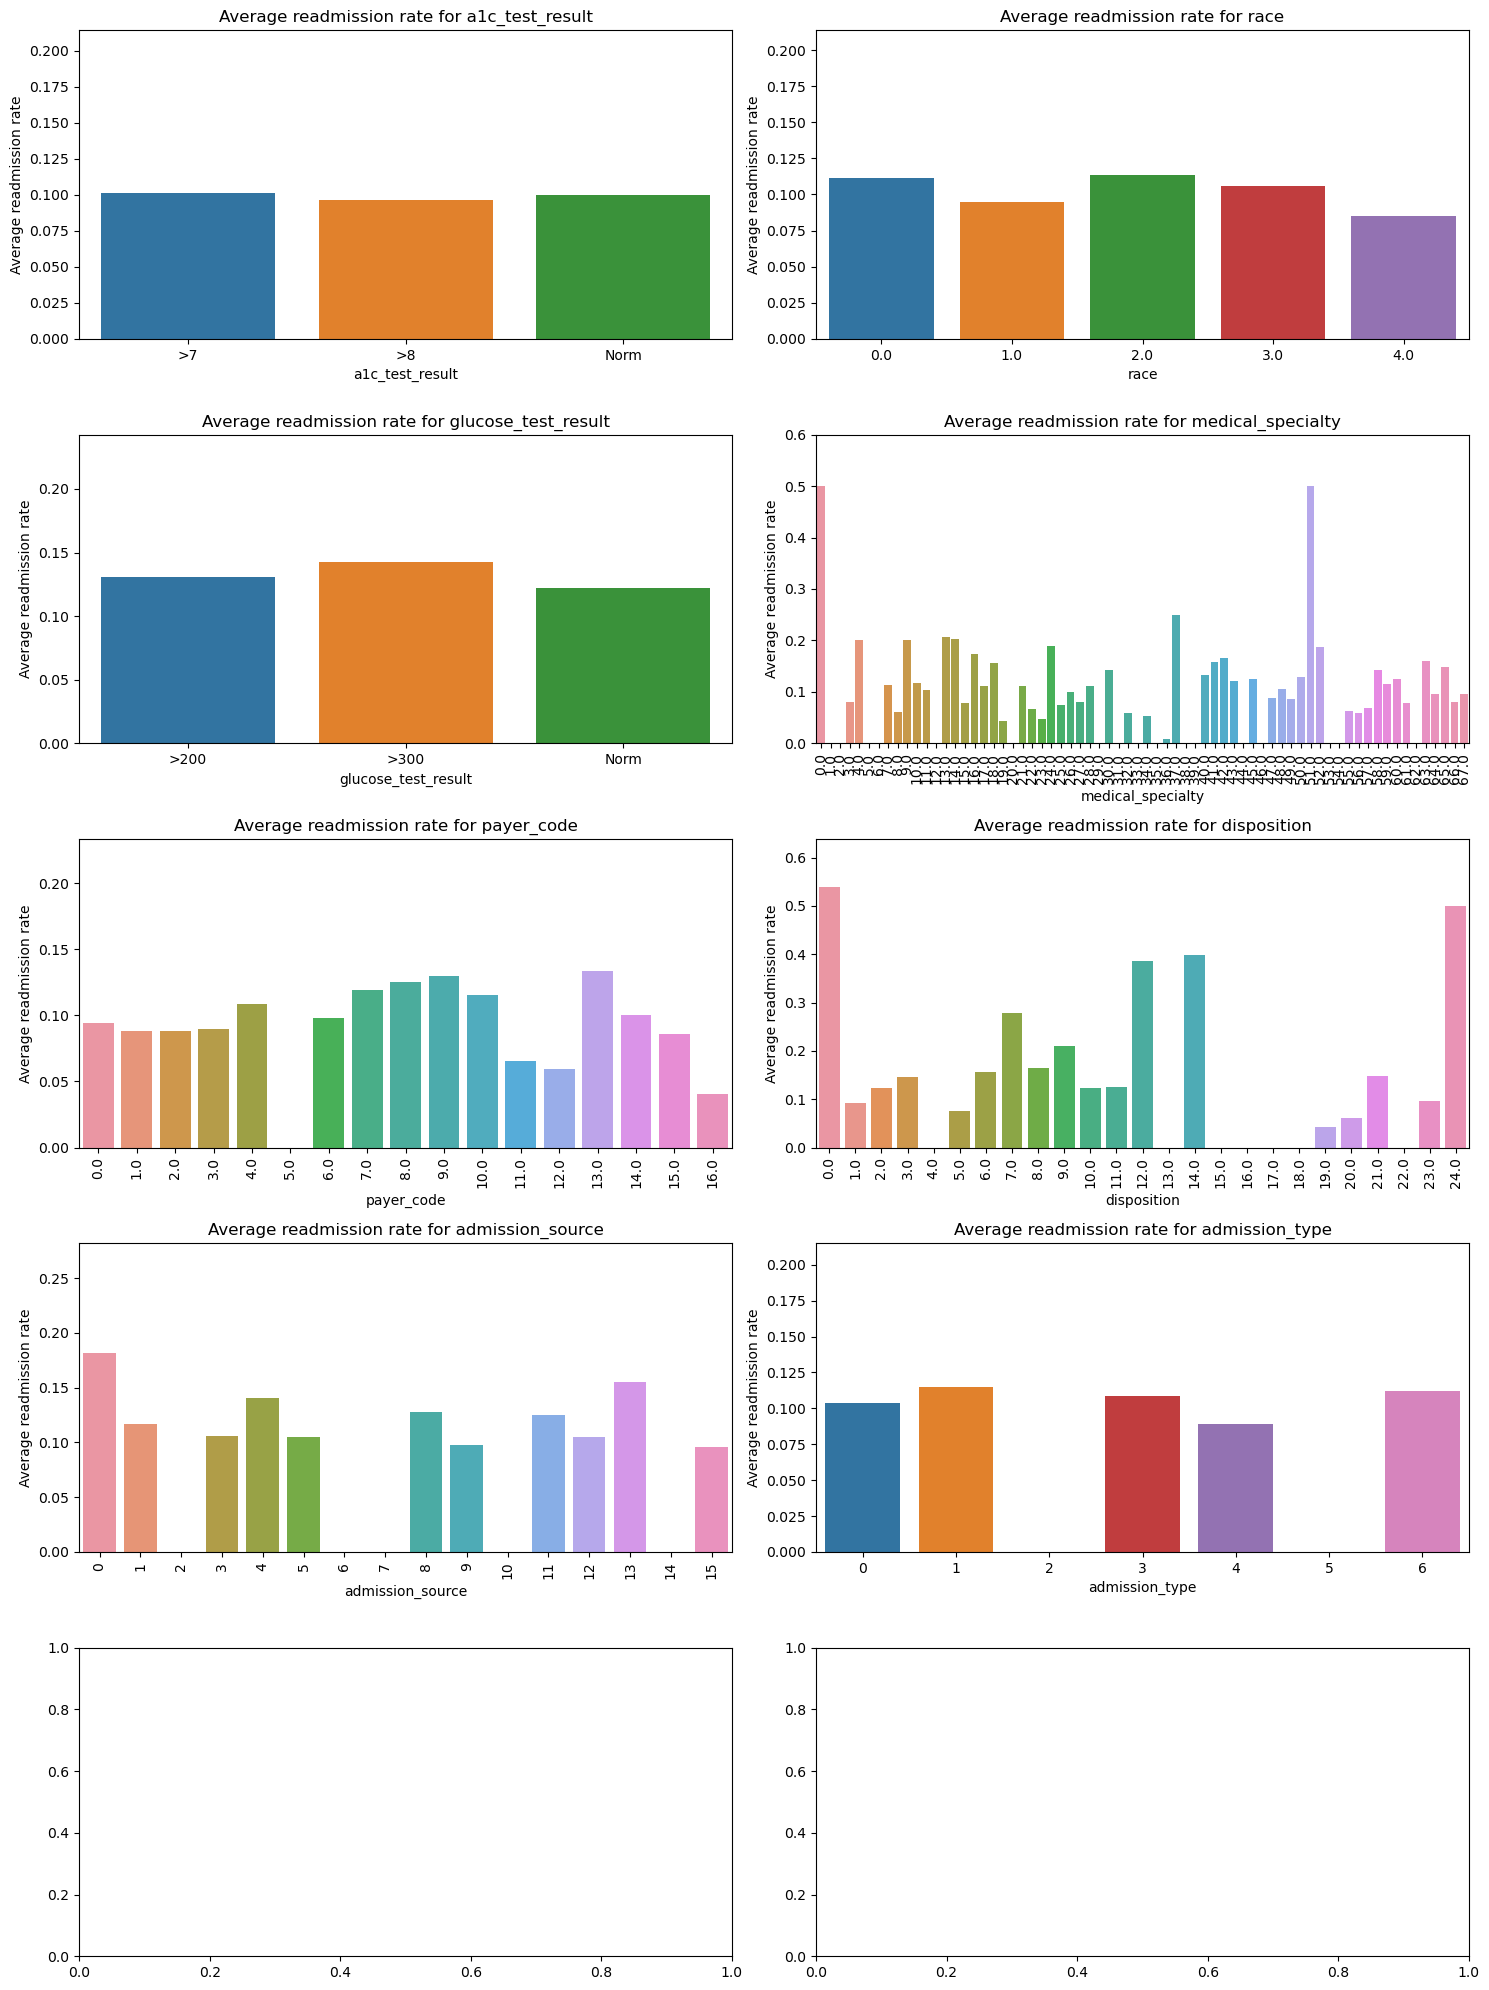

In [34]:
# Lets plot how different categorical values affect the target variable
### DIFERENÇA TO_PLOT #######
fig, ax = plt.subplots(5,2, figsize=(15,20))
to_plot = set(categorical_features) - set(['diag_1', 'diag_2', 'diag_3'])

for i, feature in enumerate(to_plot):
    sns.barplot(x=train.groupby(feature, dropna=False)['readmitted_binary'].mean().index, y=train.groupby(feature, dropna=False)['readmitted_binary'].mean().values, ax=ax[i//2][i%2])
    ax[i//2][i%2].set_title(f'Average readmission rate for {feature}')
    ax[i//2][i%2].set_xlabel(feature)
    ax[i//2][i%2].set_ylabel('Average readmission rate')
    ax[i//2][i%2].set_ylim(0,max(train.groupby(feature, dropna=False)['readmitted_binary'].mean().values)+0.1)
    # If the lenght of the xticks is too big, rotate them
    if len(train.groupby(feature, dropna=False)['readmitted_binary'].mean().index) > 10:
        ax[i//2][i%2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

3. Binary features

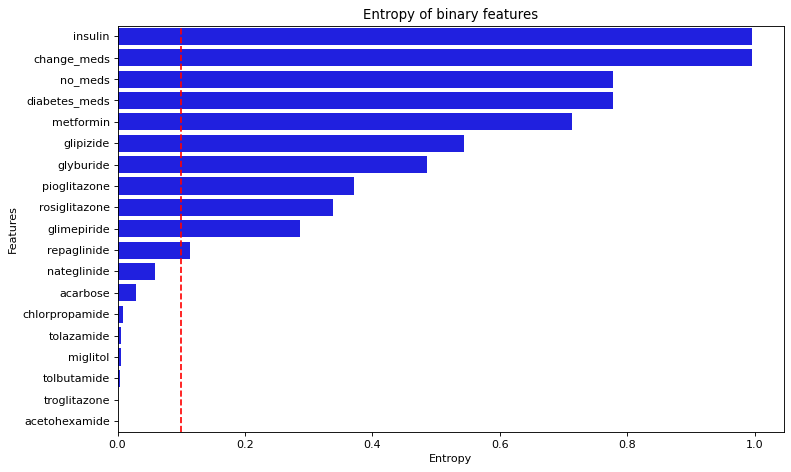

In [35]:
# Lets check the disparity between the binary features (using entropy as a measure)
binary_features = train[binary_features]
binary_features = binary_features.apply(lambda x: x.value_counts(normalize=True), axis=0)
binary_features = binary_features.T
binary_features['entropy'] = binary_features.apply(lambda x: -np.sum(x*np.log2(x)), axis=1)
binary_features.sort_values(by='entropy', inplace=True, ascending=False)

plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=binary_features['entropy'], y=binary_features.index, color='b')
plt.axvline(x=0.1, color='r', linestyle='--')
plt.title('Entropy of binary features')
plt.xlabel('Entropy')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Lets remove the features that have too low entropy to avoid overfitting.

In [36]:
to_remove = list(set(binary_features[binary_features['entropy'] < 0.1].index.tolist()))
train.drop(to_remove, axis=1, inplace=True, errors='ignore')
binary_features.drop(to_remove, axis=0, inplace=True)

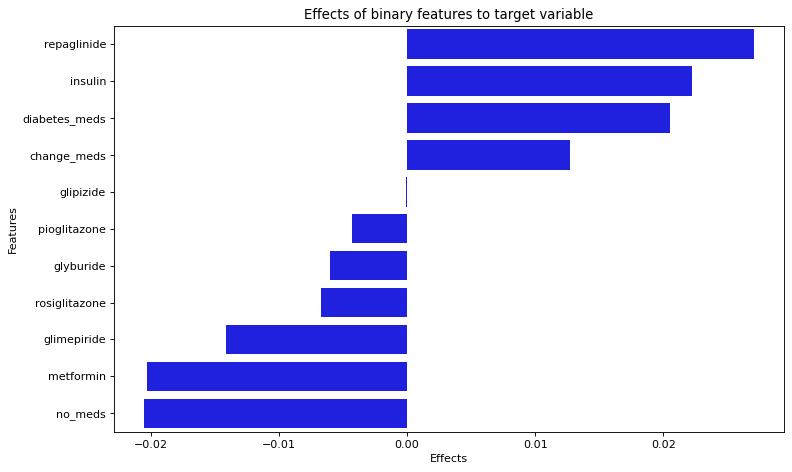

In [37]:
effects = {}
for feature in set(binary_features.index.tolist()):
    temp = train.groupby(feature)['readmitted_binary'].mean()
    effects[feature] = temp[1] - temp[0]

effects = pd.Series(effects).sort_values(ascending=False)

# Plot the effects with a barplot
plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=effects.values, y=effects.index, color='b')
plt.title('Effects of binary features to target variable')
plt.xlabel('Effects')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [38]:
# Lets remove glizipide because it doesnt affect the target variable
train.drop('glipizide', axis=1, inplace=True)

In [39]:
binary_features = list(set(binary_features.index.to_list()))

### __IV. Taking care of missing data__
Lets check for which values are missing (in percentage of the total dataframe size)

In [40]:
# Making a copy of the data
train_III = train.copy()

In [41]:
isna = (100 * train.isna().sum().sort_values(ascending=False) / len(train))
isna = isna[isna != 0]

In [42]:
isna

weight                 96.847100
glucose_test_result    94.822842
a1c_test_result        83.272503
medical_specialty      49.022966
payer_code             39.588130
race                    7.117188
age                     4.993262
disposition             3.635802
diag_3                  1.415015
diag_2                  0.367792
diag_1                  0.022461
dtype: float64

In [43]:
def get_missing_per(train):
    isna = (100 * train.isna().sum().sort_values(ascending=False) / len(train))
    isna = isna[isna != 0]

    missing_counts = 100 *train.apply(lambda x: x.value_counts().get('?', 0)).sort_values(ascending=False) / len(train)
    missing_counts = missing_counts[missing_counts != 0]

    # Remove the columns readmitted_binary and readmitted_multiclass, as these are the target variables
    #isna = isna.drop(['readmitted_binary', 'readmitted_multiclass'])
    #isna = isna.drop(isna.index[isna.index.str.contains('description')])

    return pd.concat([isna, missing_counts], axis=0).sort_values(ascending=False)

get_missing_per(train)

weight                 96.847100
glucose_test_result    94.822842
a1c_test_result        83.272503
medical_specialty      49.022966
payer_code             39.588130
race                    7.117188
age                     4.993262
disposition             3.635802
diag_3                  1.415015
diag_2                  0.367792
diag_1                  0.022461
dtype: float64

#### __0. Taking care of variables with high % of missing values__
We have many variables with a missing value count upwards of 30%, which should be removed. Lets check how they are, before removing them.

##### 1. *Weight*

In [44]:
train.groupby('weight', dropna=False)['readmitted_binary'].mean().sort_values(ascending=False)

weight
12.5     0.171429
187.5    0.142857
NaN      0.111697
62.5     0.111635
112.5    0.111359
87.5     0.109325
37.5     0.104478
162.5    0.095238
137.5    0.052083
225.0    0.000000
Name: readmitted_binary, dtype: float64

In [45]:
train.groupby('weight')['diabetes_meds'].mean().sort_values(ascending=False)

weight
225.0    1.000000
187.5    0.857143
12.5     0.771429
137.5    0.760417
87.5     0.710611
112.5    0.694878
62.5     0.676101
37.5     0.641791
162.5    0.619048
Name: diabetes_meds, dtype: float64

Although there seems to be some variance in the weight, with respect to the target variable, the missing values are too many to be imputed. We will remove this variable, as it might introduce bias in the model.

##### 2. *Glucose test results*

In [46]:
print(train.groupby('glucose_test_result',dropna=False)['readmitted_binary'].mean().sort_values(ascending=False))
print(train.groupby('a1c_test_result', dropna=False)['readmitted_binary'].mean().sort_values(ascending=False))

glucose_test_result
>300    0.142684
>200    0.130806
Norm    0.121816
NaN     0.110647
Name: readmitted_binary, dtype: float64
a1c_test_result
NaN     0.114228
>7      0.101551
Norm    0.099914
>8      0.096231
Name: readmitted_binary, dtype: float64


These two variables are very important to diagnose diabetes, and we can assume that if the test is Nan, it was not performed. We will impute the missing values with Not Performed.

We are also going to rename the columns to a1c_test_result and glucose_test_result, for better readability, and according to the following article:
<br> '*[A] diagnosis of diabetes can be made when the A1C exceeds 6.5% or when a random glycose level in a patient with classic symptoms exceeds 200 mg/dL.*' (https://www.ncbi.nlm.nih.gov/books/NBK551501/), meaning:
1. We can encode the a1c_test_result as 0 for 'Normal' and 1 for 'Diabetic', since the a1c values range from Norm, >7, >8. 
2. We will also use the glycose reading, with a threshold of >300mg/dL to encode it as 1, and 0 otherwise.
3. We can then join both dataframes, creating a new column name diabetes

In [47]:
glucose_map = {'Norm': 'Normal', '>200': 'Probably diabetic', '>300': 'Diabetic'}
a1c_map = {'Norm': 'Normal', '>7': 'Diabetic', '>8': 'Diabetic'}
train['glucose_test_result'] = train['glucose_test_result'].map(glucose_map).fillna('Not tested')
train['a1c_test_result'] = train['a1c_test_result'].map(a1c_map).fillna('Not tested')
print(train['glucose_test_result'].value_counts(), '\n')
print(train['a1c_test_result'].value_counts())

Not tested           67548
Normal                1806
Probably diabetic     1055
Diabetic               827
Name: glucose_test_result, dtype: int64 

Not tested    59320
Diabetic       8413
Normal         3503
Name: a1c_test_result, dtype: int64


##### 3. *Medical specialty*

In [48]:
train.groupby('medical_specialty')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='count', ascending=False).T

medical_specialty,17.0,7.0,10.0,3.0,59.0,18.0,26.0,27.0,49.0,48.0,45.0,67.0,23.0,57.0,11.0,65.0,61.0,41.0,24.0,32.0,14.0,19.0,36.0,29.0,64.0,8.0,43.0,47.0,56.0,34.0,13.0,12.0,50.0,15.0,55.0,25.0,28.0,63.0,66.0,16.0,21.0,52.0,40.0,22.0,31.0,2.0,60.0,39.0,58.0,30.0,46.0,42.0,0.0,9.0,4.0,1.0,37.0,6.0,62.0,51.0,5.0,33.0,53.0,54.0,44.0,20.0,38.0,35.0
mean,0.111543,0.113179,0.117117,0.079386,0.114739,0.15669,0.100629,0.079585,0.085679,0.106383,0.125418,0.096234,0.047009,0.068966,0.103275,0.147945,0.078125,0.157143,0.1893,0.05914,0.202614,0.043478,0.008264,0.0,0.096386,0.061728,0.121622,0.088235,0.059701,0.052632,0.207547,0.0,0.128205,0.078947,0.0625,0.074074,0.111111,0.16,0.08,0.173913,0.111111,0.1875,0.133333,0.066667,0.0,0.0,0.125,0.0,0.142857,0.142857,0.0,0.166667,0.5,0.2,0.2,0.0,0.25,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count,10292.000000,5319.000000,5217.000000,3716.000000,2144.000000,1136.00000,954.000000,867.000000,817.000000,611.000000,598.000000,478.000000,468.000000,464.000000,397.000000,365.000000,320.000000,280.000000,243.0000,186.00000,153.000000,138.000000,121.000000,86.0,83.000000,81.000000,74.000000,68.000000,67.000000,57.000000,53.000000,50.0,39.000000,38.000000,32.0000,27.000000,27.000000,25.00,25.00,23.000000,18.000000,16.0000,15.000000,15.000000,13.0,12.0,8.000,8.0,7.000000,7.000000,6.0,6.000000,6.0,5.0,5.0,5.0,4.00,4.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0


In [49]:
train[['medical_specialty','diag_1']].value_counts(dropna=False).head(10)

medical_specialty  diag_1
NaN                250       2937
                   428       2455
                   414       1957
                   410       1395
                   786       1318
3.0                414       1284
NaN                486       1260
17.0               250       1133
NaN                427        966
                   491        954
dtype: int64

Medical speciality is a tricky one. We have a lot of missing values, but it can explain some of the variance in the target variable. We could try to input the missing values with the help of the primary_diagnosis variable, but then we would just have the same data twice. We will remove this variable.

##### 4. *Insurance provider code*

In [50]:
train.groupby('payer_code',dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
payer_code,,
13.0,0.133333,45
9.0,0.129630,54
8.0,0.125201,2484
7.0,0.118900,22683
10.0,0.115226,729
NaN,0.115209,28201
4.0,0.108466,378
14.0,0.100537,3541
6.0,0.097939,4319


We won't remove this variable, because if there is no code, probably the person doesn't have an insurance provider. Instead we are going to input 'no insurance' to the missing (represented by value "-1"), and 'Other' to very low count values (represented by value "99"), so we can use it later on.

In [51]:
train['payer_code'].fillna("-1", inplace=True)

# For counts below 1% we will replace with 'Other'
providor_proportion = train['payer_code'].value_counts(normalize=True)
change = providor_proportion[providor_proportion < 0.01].index
train['payer_code'] = train['payer_code'].replace(change, 99)

In [52]:
train['payer_code'].value_counts()

-1      28201
7.0     22683
6.0      4319
14.0     3541
0.0      3292
8.0      2484
3.0      1762
15.0     1733
2.0      1347
99       1145
10.0      729
Name: payer_code, dtype: int64

##### 5. Removing variables mentioned above

In [53]:
weight = train['weight']
medical_specialty = train['medical_specialty']
train = train.drop(['weight', 'medical_specialty'], axis=1, errors='ignore')
categorical_features = list(set(categorical_features) - set(['medical_specialty']))

#### __1. Managing the variable race__

In [54]:
get_missing_per(train)

race           7.117188
age            4.993262
disposition    3.635802
diag_3         1.415015
diag_2         0.367792
diag_1         0.022461
dtype: float64

1.1. Using first the "patient_id" to input the missing values.

In [55]:
ids_race_missing = train[train['race'].isna()]['patient_id'].unique()
train_race = train[train['race'].notna()]
intersect = train_race[train_race['patient_id'].isin(ids_race_missing)]

# From those, there are repeated patient_ids, so lets check how many unique patient_ids there are
print('Unique patient_ids: ', len(intersect['patient_id'].unique()))
print('Total patient_ids missing: ', len(ids_race_missing))

Unique patient_ids:  1354
Total patient_ids missing:  4841


In [56]:
missingRace = train[train['race'].isna()]
missingRace = missingRace[missingRace['patient_id'].isin(intersect['patient_id'].unique())]

# Let's now fill the ids_missing with the first patient id value that is not missing
patient_race_mapping = train_race.groupby('patient_id')['race'].first()
mapper = missingRace.apply(lambda row: patient_race_mapping[row['patient_id']] if pd.isna(row['race']) else row['race'], axis=1)

# Now lets fill the missing values
train.loc[mapper.index, 'race'] = mapper

1.2. If the race was not registered, then it probably means the visit was short. Lets keep the nans as Not Registered, as this could prove valuable latter on.

In [57]:
# Lets see how race is distributed
train.groupby('race', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='count', ascending=False)

,mean,count
race,,
2.0,0.115553,51777
0.0,0.113037,12978
NaN,0.060581,3648
3.0,0.106810,1395
4.0,0.087945,1012
1.0,0.096244,426


Race doesn't seem to be correlated to anything, so using a KNN algorithm doesn't make a lot of sense. Let's just use the most common value to fill in the missing values. Although, we will be introducing a bias, as the mean of the NaNs values for the target variable is different from the mean of class 2 (caucasian).

In [58]:
train['race'].fillna('Not Registered', inplace=True)

In [59]:
train.groupby('race', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='count', ascending=False)

,mean,count
race,,
2.0,0.115553,51777
0.0,0.113037,12978
Not Registered,0.060581,3648
3.0,0.106810,1395
4.0,0.087945,1012
1.0,0.096244,426


#### __2. Handling the variable age__

In [60]:
get_missing_per(train)

age            4.993262
disposition    3.635802
diag_3         1.415015
diag_2         0.367792
diag_1         0.022461
dtype: float64

2.1. Let's use patient id to infer the age, as we previously did for race.

In [61]:
ids_age_missing = train[train['age'].isna()]['patient_id'].unique()
train_age = train[train['age'].notna()]
intersect = train_age[train_age['patient_id'].isin(ids_age_missing)]

# From those, there are repeated patient_ids, so lets check how many unique patient_ids there are
print('Unique patient_ids: ', len(intersect['patient_id'].unique()))
print('Total patient_ids missing: ', len(ids_age_missing))

Unique patient_ids:  1294
Total patient_ids missing:  3489


In [62]:
missingAge = train[train['age'].isna()]
missingAge = missingAge[missingAge['patient_id'].isin(intersect['patient_id'].unique())]

# Let's now fill the ids_missing with the first patient id value that is not missing
patient_age_mapping = train_age.groupby('patient_id')['age'].first()
mapper = missingAge.apply(lambda row: patient_age_mapping[row['patient_id']] if pd.isna(row['age']) else row['age'], axis=1)

# Now lets fill the missing values
train.loc[mapper.index, 'age'] = mapper

2.2. If the age was not registered, then it probably means the visit was short. Let's keep the NaNs as "Not Registered", as this could prove valuable later on.

In [63]:
train.groupby('age', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=True)

,mean,count
age,,
5.0,0.009524,105
NaN,0.058638,2217
15.0,0.062370,481
55.0,0.101346,11663
45.0,0.106100,6541
35.0,0.110596,2586
65.0,0.110650,15165
95.0,0.116754,1910
75.0,0.119131,17720


We will fill the missing values with 10, because it is between the mean of 5 and 15. Since we will then change the variable to a categorical one, it is okay to do this, as we just want to keep the order of the categories.

In [64]:
train['age'].fillna('10', inplace=True)

#### __3. Filling in the variable disposition__

In [65]:
get_missing_per(train)

disposition    3.635802
diag_3         1.415015
diag_2         0.367792
diag_1         0.022461
dtype: float64

In [66]:
train.groupby('disposition', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='count', ascending=False).T

disposition,1.0,3.0,11.0,NaN,8.0,7.0,16.0,9.0,23.0,2.0,21.0,5.0,20.0,19.0,14.0,10.0,12.0,6.0,0.0,15.0,13.0,17.0,4.0,22.0,24.0,18.0
mean,0.092744,0.146217,0.126374,0.127799,0.165323,0.278536,0.0,0.209246,0.097202,0.124343,0.147268,0.075,0.061303,0.042636,0.397959,0.123457,0.386364,0.15625,0.538462,0.0,0.0,0.0,0.0,0.0,0.5,0.0
count,42256.000000,9780.000000,9005.000000,2590.000000,1488.000000,1393.000000,1135.0,822.000000,679.000000,571.000000,421.000000,280.000,261.000000,258.000000,98.000000,81.000000,44.000000,32.00000,13.000000,8.0,7.0,6.0,3.0,2.0,2.0,1.0


Let's fill the missing values with the most common value with the nearest mean target variable. (????)

In [67]:
train['disposition'].fillna(11, inplace=True)

#### __4. Addressing the diagnosis variables__

In [68]:
get_missing_per(train)

diag_3    1.415015
diag_2    0.367792
diag_1    0.022461
dtype: float64

"NaN" values in the "diagnosis" features could just mean no diagnosis, so we will fill them with 'No Diagnosis'.

In [69]:
train['diag_1'] = train['diag_1'].fillna('No Diagnosis')
train['diag_2'] = train['diag_2'].fillna('No Diagnosis')
train['diag_3'] = train['diag_3'].fillna('No Diagnosis')

#### __4. Addressing the gender variable__

In [70]:
get_missing_per(train)

Series([], dtype: float64)

In [71]:
#ids_gender_missing = train[train['gender'].isna()]['patient_id'].unique()
#train_gender = train[train['gender'].notna()]
#intersect = train_gender[train_gender['patient_id'].isin(ids_gender_missing)]

#From those, there are repeated patient_ids, so lets check how many unique patient_ids there are
#print('Unique patient_ids: ', len(intersect['patient_id'].unique()))
#print('Total patient_ids missing: ', len(ids_gender_missing))

In [72]:
#missingGender = train[train['gender'].isna()]
#missingGender = missingGender[missingGender['patient_id'].isin(intersect['patient_id'].unique())]

# Let's now fill the ids_missing with the first patient id value that is not missing
#patient_gender_mapping = train_race.groupby('patient_id')['gender'].first()
#mapper = missingGender.apply(lambda row: patient_gender_mapping[row['patient_id']] if pd.isna(row['gender']) else row['gender'], axis=1)

# Now lets fill the missing values
#train.loc[mapper.index, 'gender'] = mapper

In [73]:
#train['gender'].fillna('Not Registered', inplace=True)

### __V. Handling Outliers and simplifying variables__
- Numerical features
- Categorical
- Binary

In [74]:
# Lets save a backup of the data
train_IV = train.copy()

In [75]:
# Lets update for the variables we have changed. Age should also be considered a categorical variable
numerical_features = list(set(numerical_features) - set(['average_pulse_bpm', 'weight', 'age']))
categorical_features = list(set(categorical_features) - set(['payer_code'])) + ['age']

##### __1. Numerical features__

In [76]:
numerical_features

['num_meds',
 'num_tests',
 'emvisits',
 'outvisits',
 'length_stay',
 'invisits',
 'num_diag',
 'non_lab_procedures']

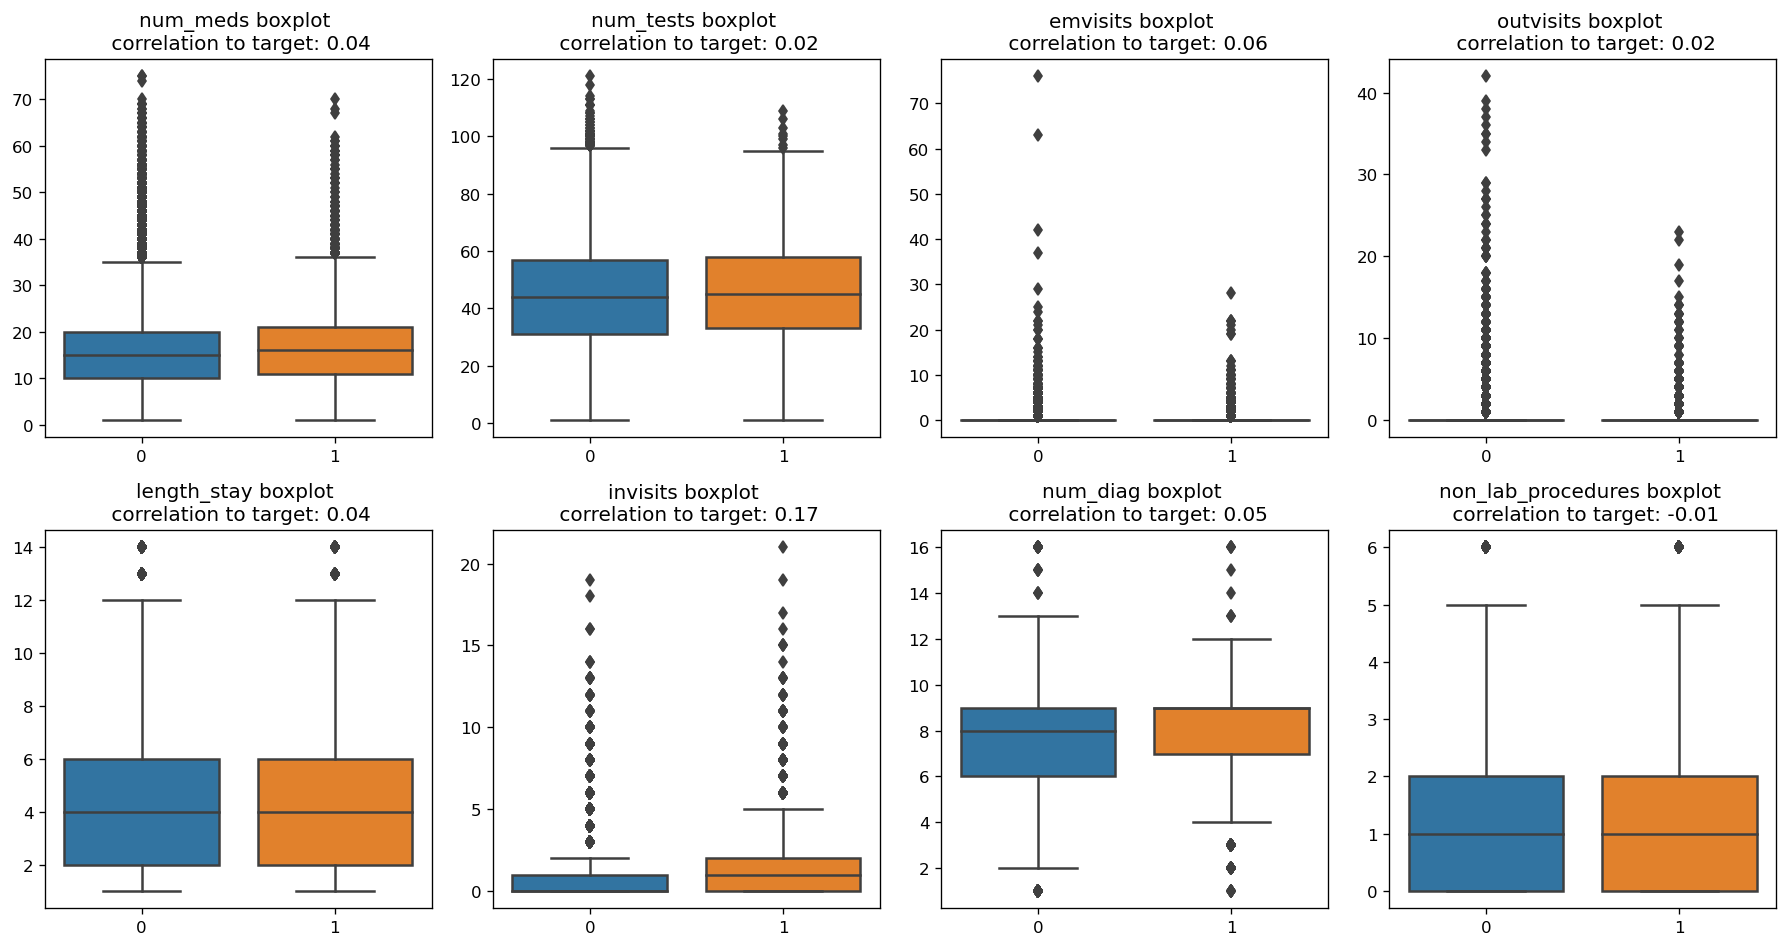

In [77]:
# Lets plot the boxplots for the numerical features
cols_ = 4
rows_ = int(round(len(numerical_features) / cols_))

fig, axes = plt.subplots(rows_, cols_, figsize=(15, 8), dpi=120)

for i, feature in enumerate(numerical_features):
    correlation = train[feature].corr(train['readmitted_binary'])
    sns.boxplot(x='readmitted_binary', y=feature, data=train, ax=axes[i//cols_, i%cols_])
    axes[i//cols_, i%cols_].set_title(f'{feature} boxplot \n correlation to target: {round(correlation, 2)}')
    axes[i//cols_, i%cols_].set_xlabel('')
    axes[i//cols_, i%cols_].set_ylabel('')

plt.tight_layout()
plt.show()

There are many outliers in "emvisits", "outvisits", "invisits". The problem with these variables is that most of them are 0, so there are very few values that are not 0, and they are very far from the mean.

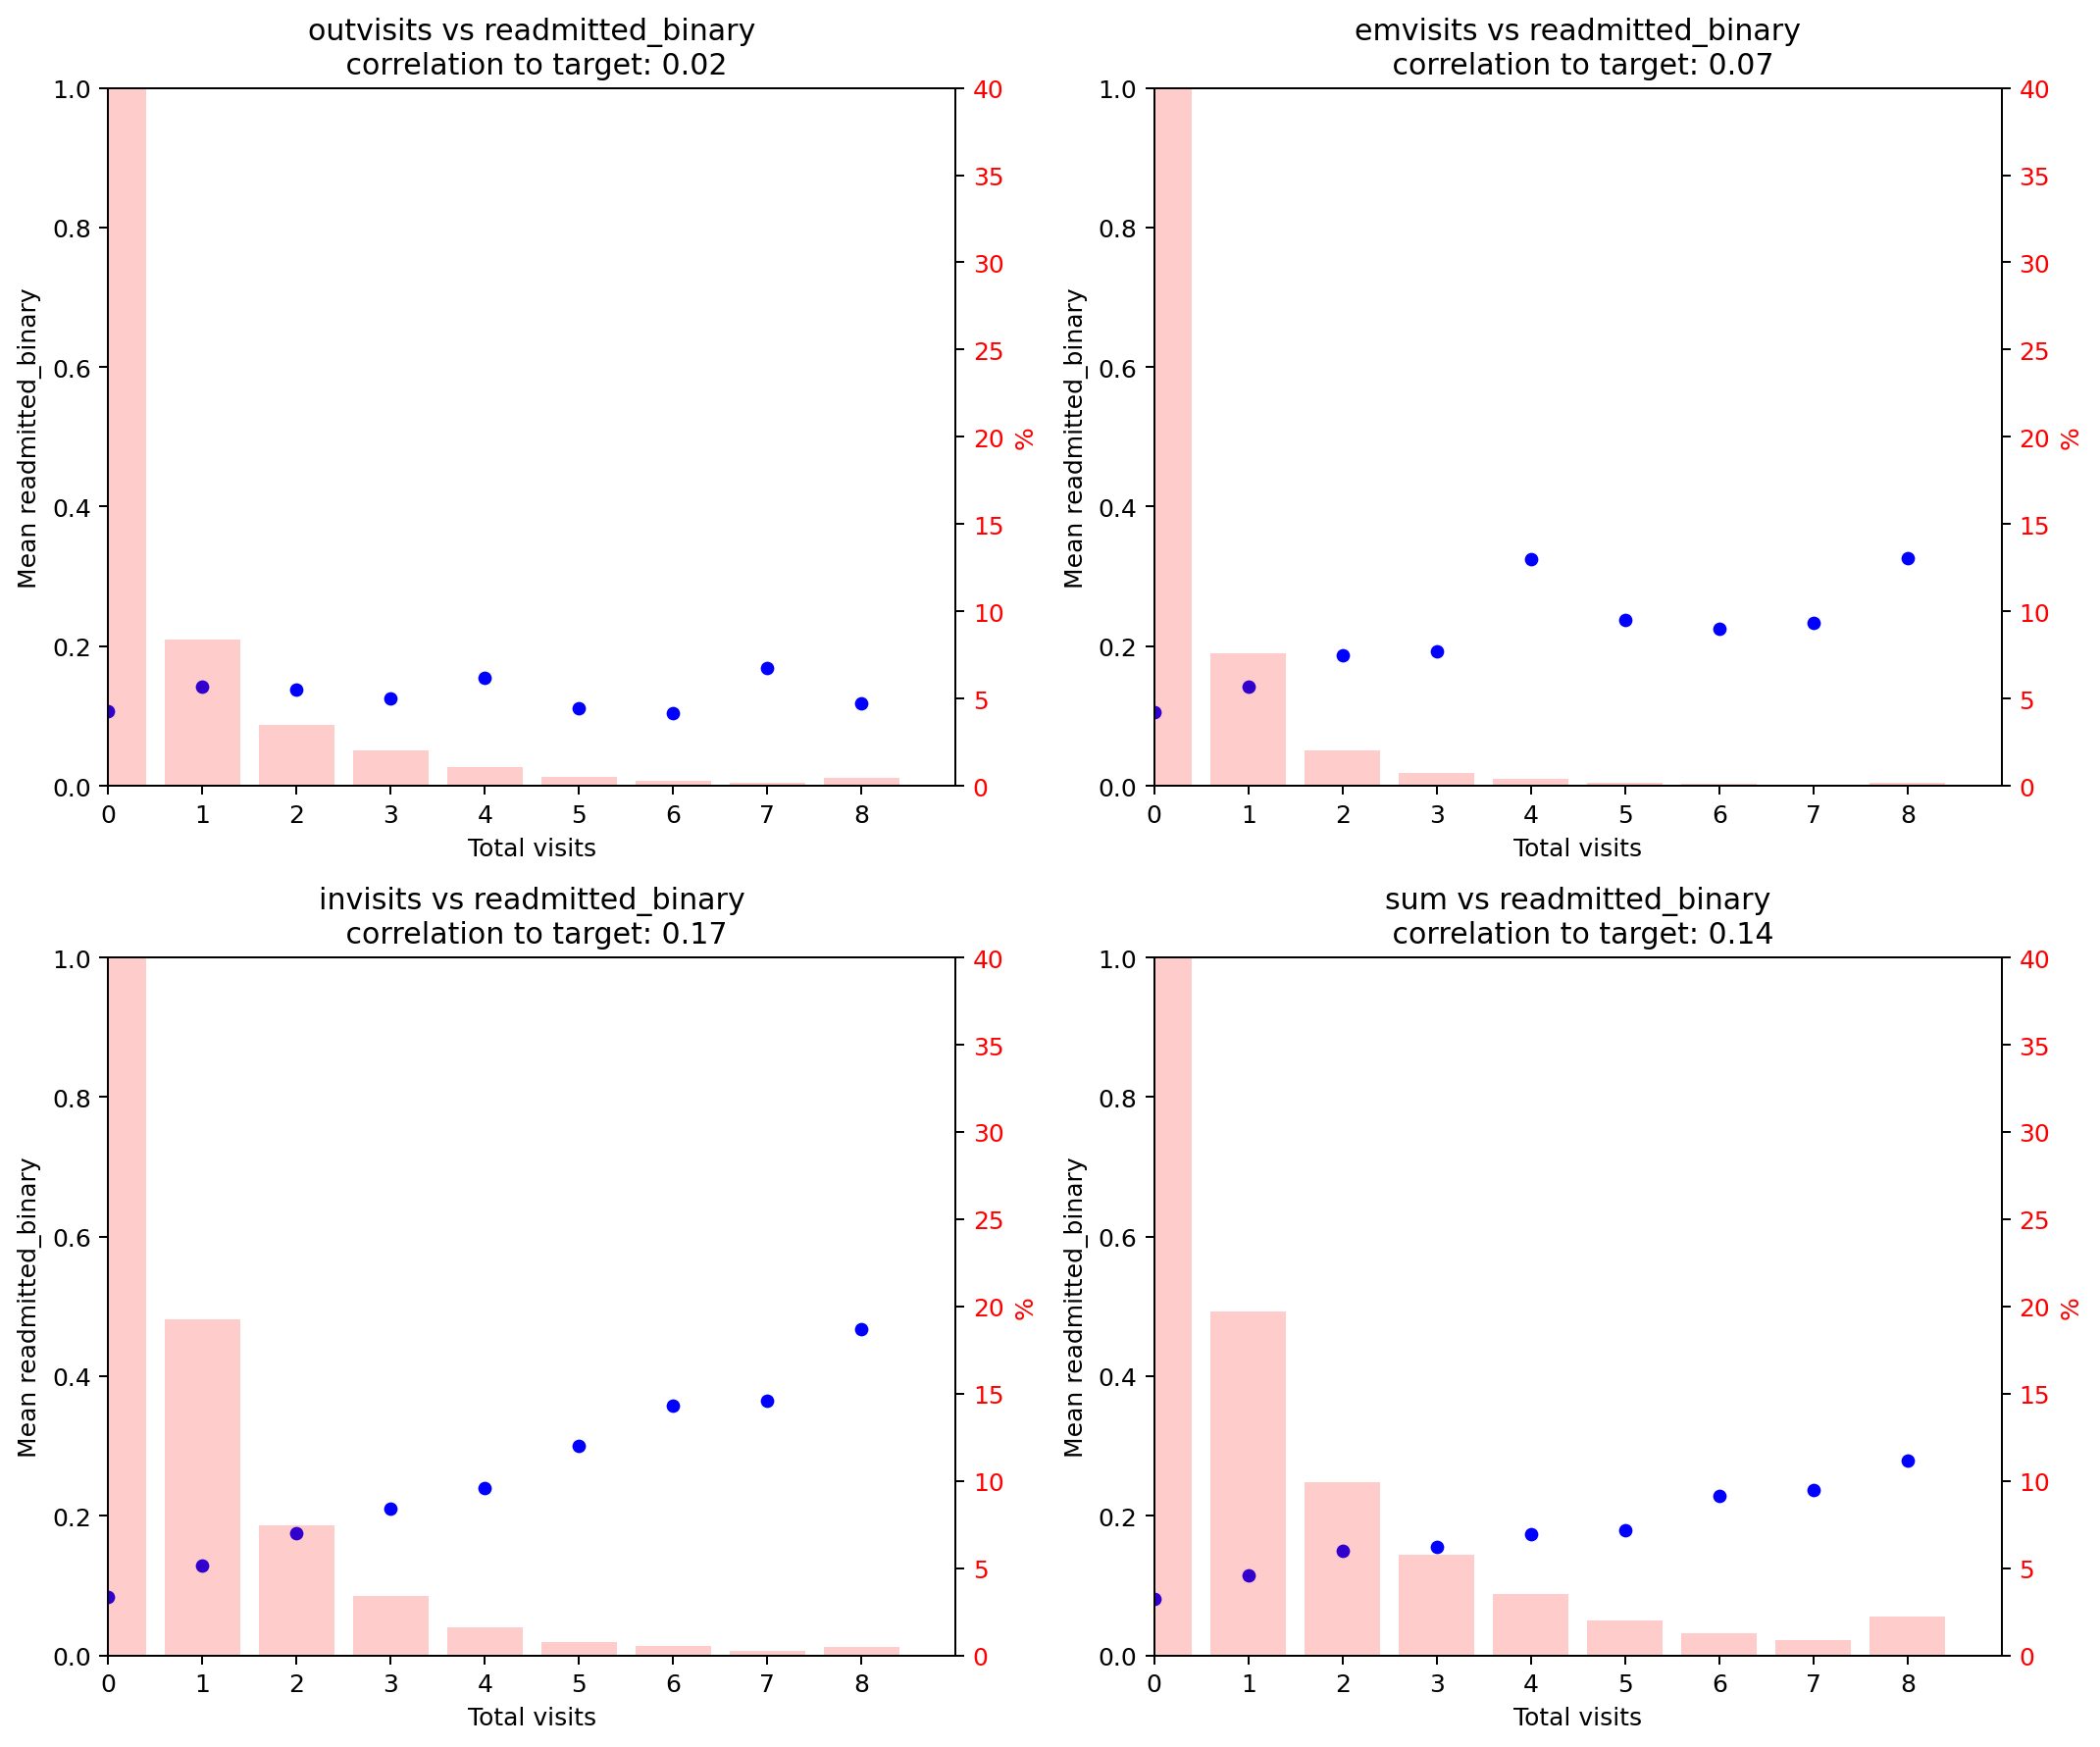

In [78]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), dpi=180)
alpha = 8

for i, feature in enumerate(['outvisits', 'emvisits', 'invisits', 'sum']):
    modified_train = train.copy()
    if feature != 'sum':
        modified_train['new_feature'] = modified_train[feature] 
    else:
        modified_train['new_feature'] = modified_train['outvisits'] + modified_train['emvisits'] + modified_train['invisits']
    modified_train.loc[modified_train['new_feature'] > alpha, 'new_feature'] = alpha
    to_plot = modified_train.groupby('new_feature')['readmitted_binary'].mean()
    correlation = modified_train['new_feature'].corr(modified_train['readmitted_binary'])

    sns.scatterplot(x=to_plot.index, y=to_plot.values, color='b', ax=ax[i//2, i%2])
    # Add on another axis how many values are in each bin
    ax2 = ax[i//2, i%2].twinx()
    ax2.bar(to_plot.index, 100*modified_train.groupby('new_feature')['readmitted_binary'].count()/len(modified_train), alpha=0.2, color='r')
    ax2.grid(False)
    ax2.set_ylabel('%', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(0, 40)

    ax[i//2, i%2].set_title(f'{feature} vs readmitted_binary\n correlation to target: {round(correlation, 2)}')
    ax[i//2, i%2].set_xlabel('Total visits')
    ax[i//2, i%2].set_ylabel('Mean readmitted_binary')
    ax[i//2, i%2].set_xticks(range(0, alpha+1))
    ax[i//2, i%2].set_xticklabels(range(0, alpha+1))
    ax[i//2, i%2].set_xlim(0, alpha+1)
    ax[i//2, i%2].set_ylim(0, 1)


plt.tight_layout()
plt.show()

Let's keep the sum of these variables and the "invisits", and drop the rest.

In [79]:
train['sum_visits'] = train['outvisits'] + train['emvisits'] + train['invisits']
#outvisits, emvisits = train['outvisits'], train['emvisits']
#train.drop(['outvisits', 'emvisits'], axis=1, inplace=True)
#numerical_features = list(set(numerical_features) - set(['outvisits', 'emvisits'])) + ['sum_visits']

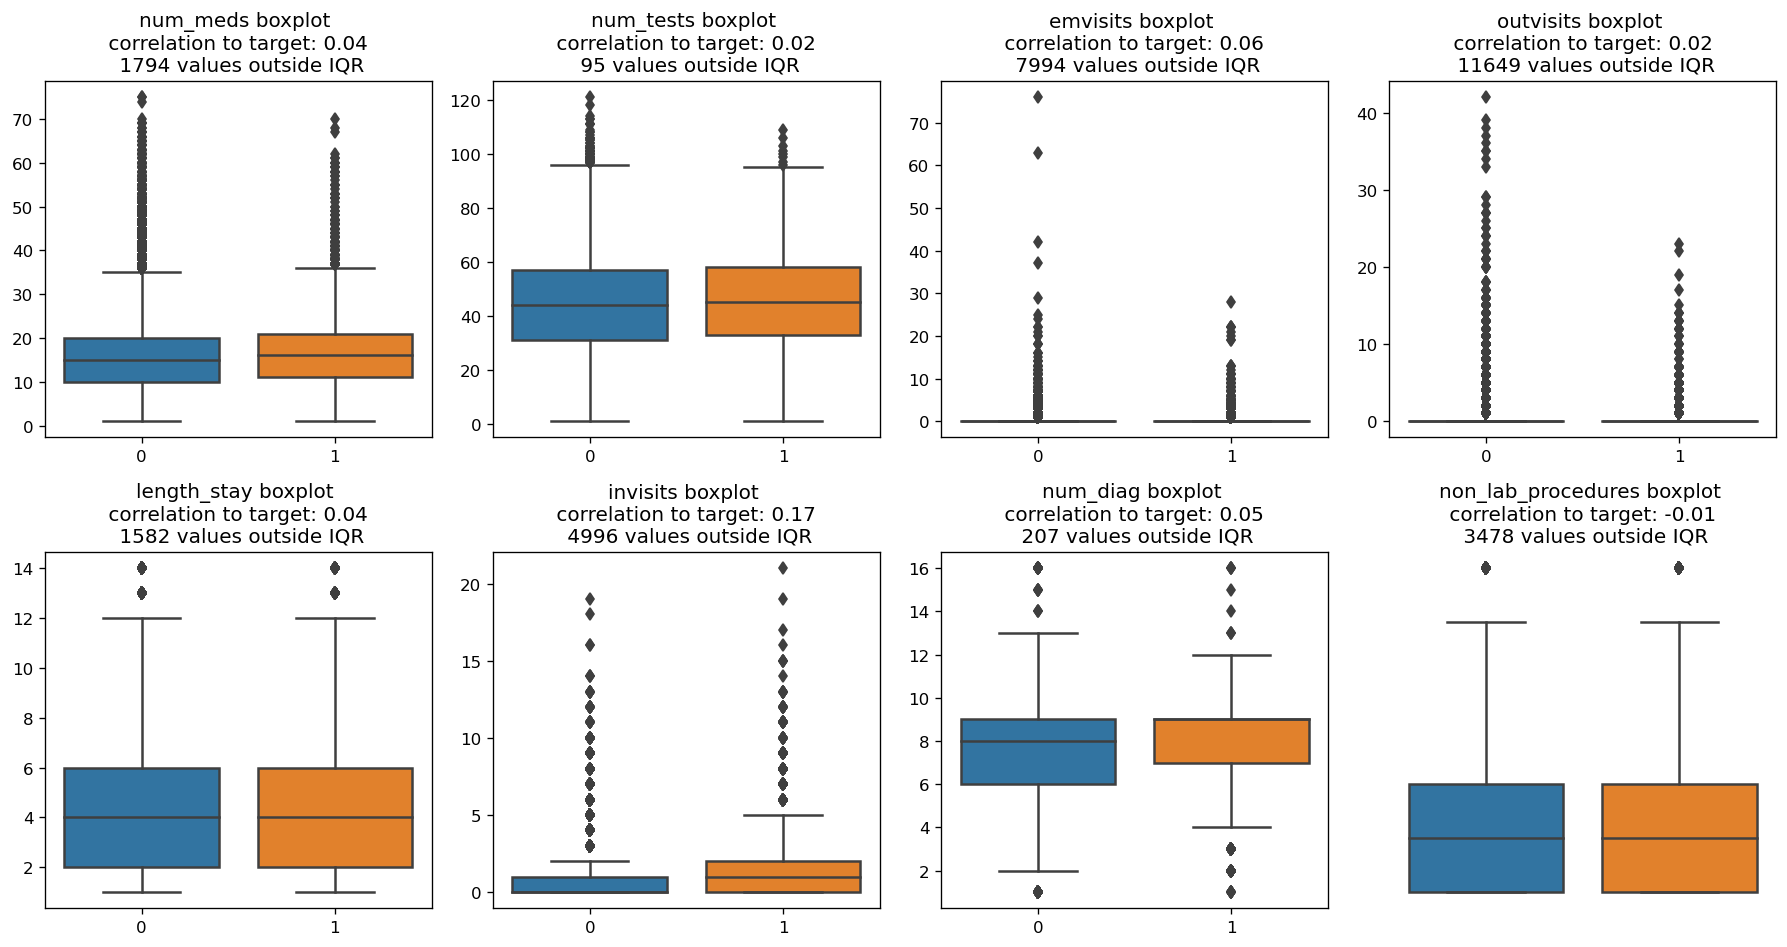

In [80]:
# Lets plot the boxplots for the numerical features
cols_ = 4
rows_ = int(round(len(numerical_features) / cols_))

fig, axes = plt.subplots(rows_, cols_, figsize=(15, 8), dpi=120)

for i, feature in enumerate(numerical_features):
    correlation = train[feature].corr(train['readmitted_binary'])
    outside_iqr_count = len(train[(train[feature] > train[feature].quantile(0.75) + 1.5*(train[feature].quantile(0.75) - train[feature].quantile(0.25))) | (train[feature] < train[feature].quantile(0.25) - 1.5*(train[feature].quantile(0.75) - train[feature].quantile(0.25)))])
    sns.boxplot(x='readmitted_binary', y=feature, data=train, ax=axes[i//cols_, i%cols_])
    axes[i//cols_, i%cols_].set_title(f'{feature} boxplot \n correlation to target: {round(correlation, 2)} \n {outside_iqr_count} values outside IQR')
    axes[i//cols_, i%cols_].set_xlabel('')
    axes[i//cols_, i%cols_].set_ylabel('')

# Remove the last axis
axes[rows_-1, cols_-1].axis('off')
plt.tight_layout()
plt.show()

__invisits and sum_visits:__ for values above the threshold "alpha" = 4, we will replace them with alpha, as they are very far from the mean, and there are very few of them.

In [81]:
alpha = 4
pure_invisits = train['invisits'].copy()
pure_emvisits = train['emvisits'].copy()
pure_outvisits = train['outvisits'].copy()
pure_visits = train['sum_visits'].copy()

train.loc[train['invisits'] > alpha, 'invisits'] = alpha
train.loc[train['outvisits'] > alpha, 'outvisits'] = alpha
train.loc[train['emvisits'] > alpha, 'emvisits'] = alpha
train.loc[train['sum_visits'] > alpha, 'sum_visits'] = alpha

In [82]:
pure_invisits

encounter_id
100000    0
100020    0
100022    0
100076    0
100078    0
         ..
999940    0
999953    0
999966    1
999968    3
999980    0
Name: invisits, Length: 71236, dtype: int64

__num_meds:__ lets do the same for num_meds

<Axes: title={'center': 'Average readmission rate for number of medications'}, xlabel='num_meds'>

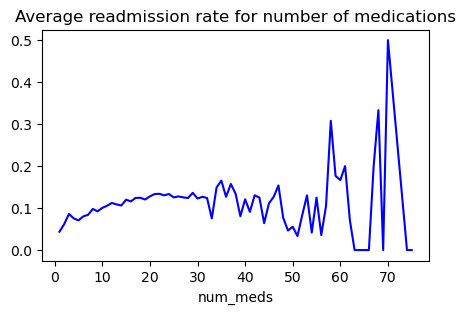

In [83]:
train.groupby('num_meds')['readmitted_binary'].mean().plot(title='Average readmission rate for number of medications', figsize=(5,3), color='b')

There seems to be a nonlinear relationship between "num_meds" and the target variable, so let's create a new variable "num_meds_squared". Also. let's crop "num_meds" from 55 onwards.

In [84]:
beta = 5

pure_num_meds = train['num_meds'].copy()
pure_num_meds_sq = train['num_meds'].copy() ** 2
train.loc[train['num_meds'] > beta, 'num_meds'] = beta
train['num_meds_sq'] = train['num_meds']**2

__num_tests:__

In [85]:
pure_num_tests = train['num_tests'].copy()
train.loc[train['num_tests'] > 100, 'num_tests'] = 100

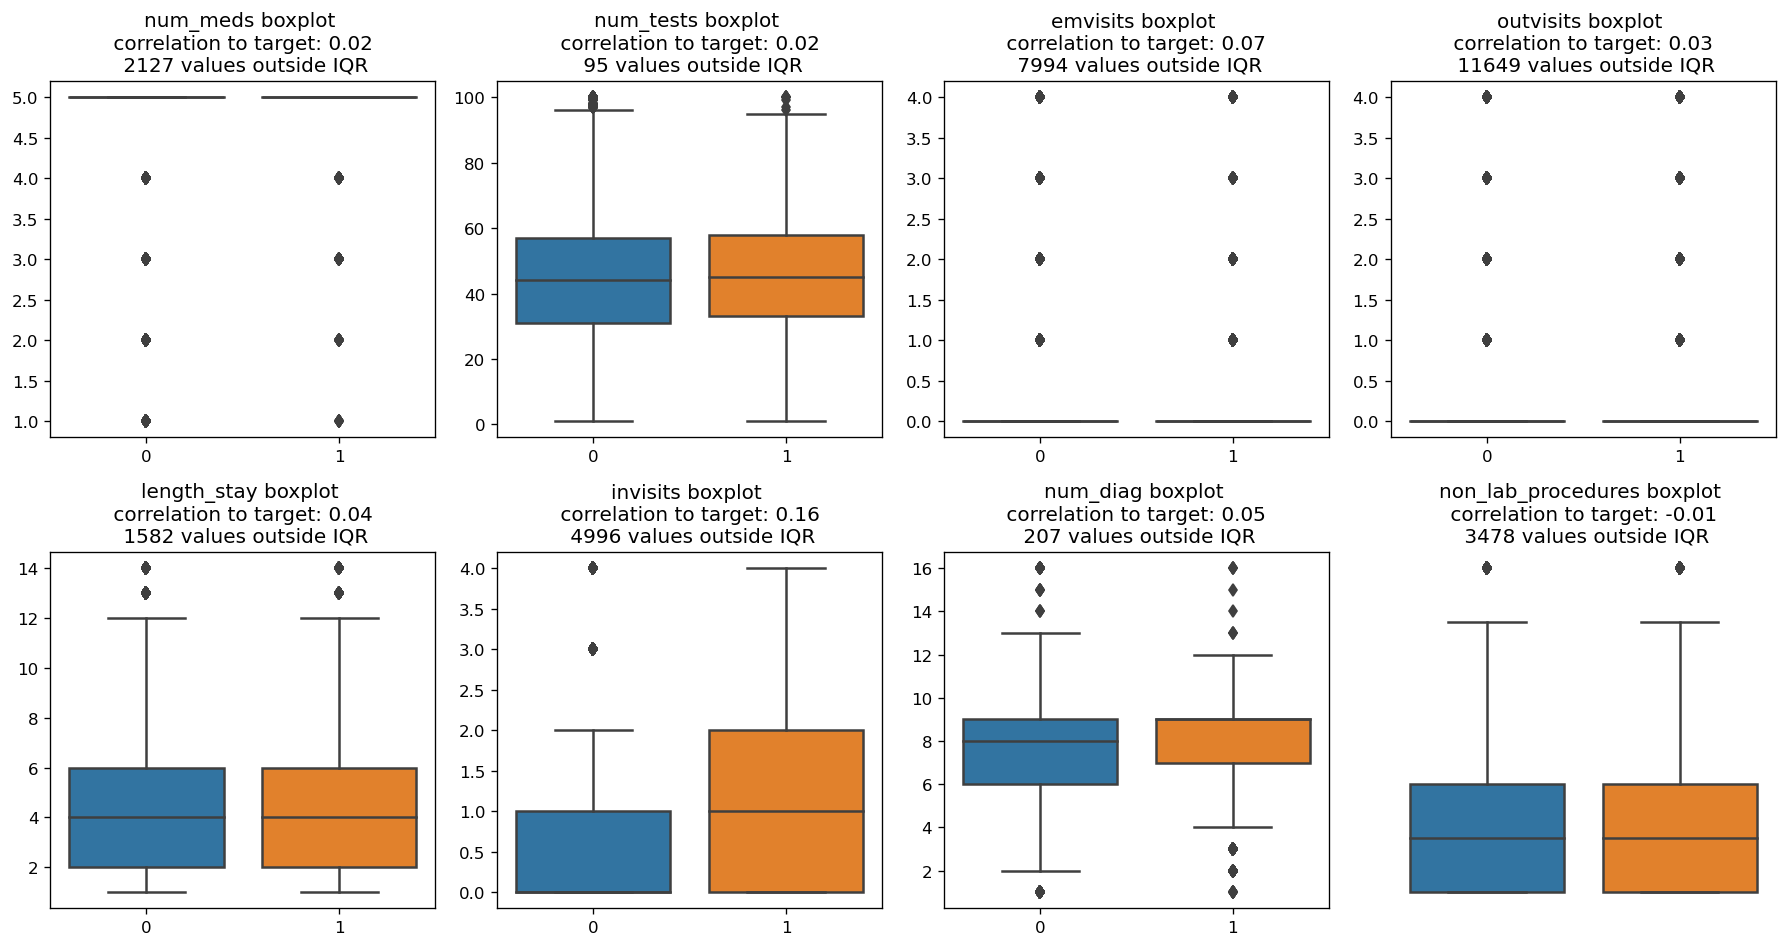

In [86]:
# Lets plot the boxplots for the numerical features
cols_ = 4
rows_ = int(round(len(numerical_features) / cols_))

fig, axes = plt.subplots(rows_, cols_, figsize=(15, 8), dpi=120)

for i, feature in enumerate(numerical_features):
    correlation = train[feature].corr(train['readmitted_binary'])
    outside_iqr_count = len(train[(train[feature] > train[feature].quantile(0.75) + 1.5*(train[feature].quantile(0.75) - train[feature].quantile(0.25))) | (train[feature] < train[feature].quantile(0.25) - 1.5*(train[feature].quantile(0.75) - train[feature].quantile(0.25)))])
    sns.boxplot(x='readmitted_binary', y=feature, data=train, ax=axes[i//cols_, i%cols_])
    axes[i//cols_, i%cols_].set_title(f'{feature} boxplot \n correlation to target: {round(correlation, 2)} \n {outside_iqr_count} values outside IQR')
    axes[i//cols_, i%cols_].set_xlabel('')
    axes[i//cols_, i%cols_].set_ylabel('')

# Remove the last axis
axes[rows_-1, cols_-1].axis('off')
plt.tight_layout()
plt.show()

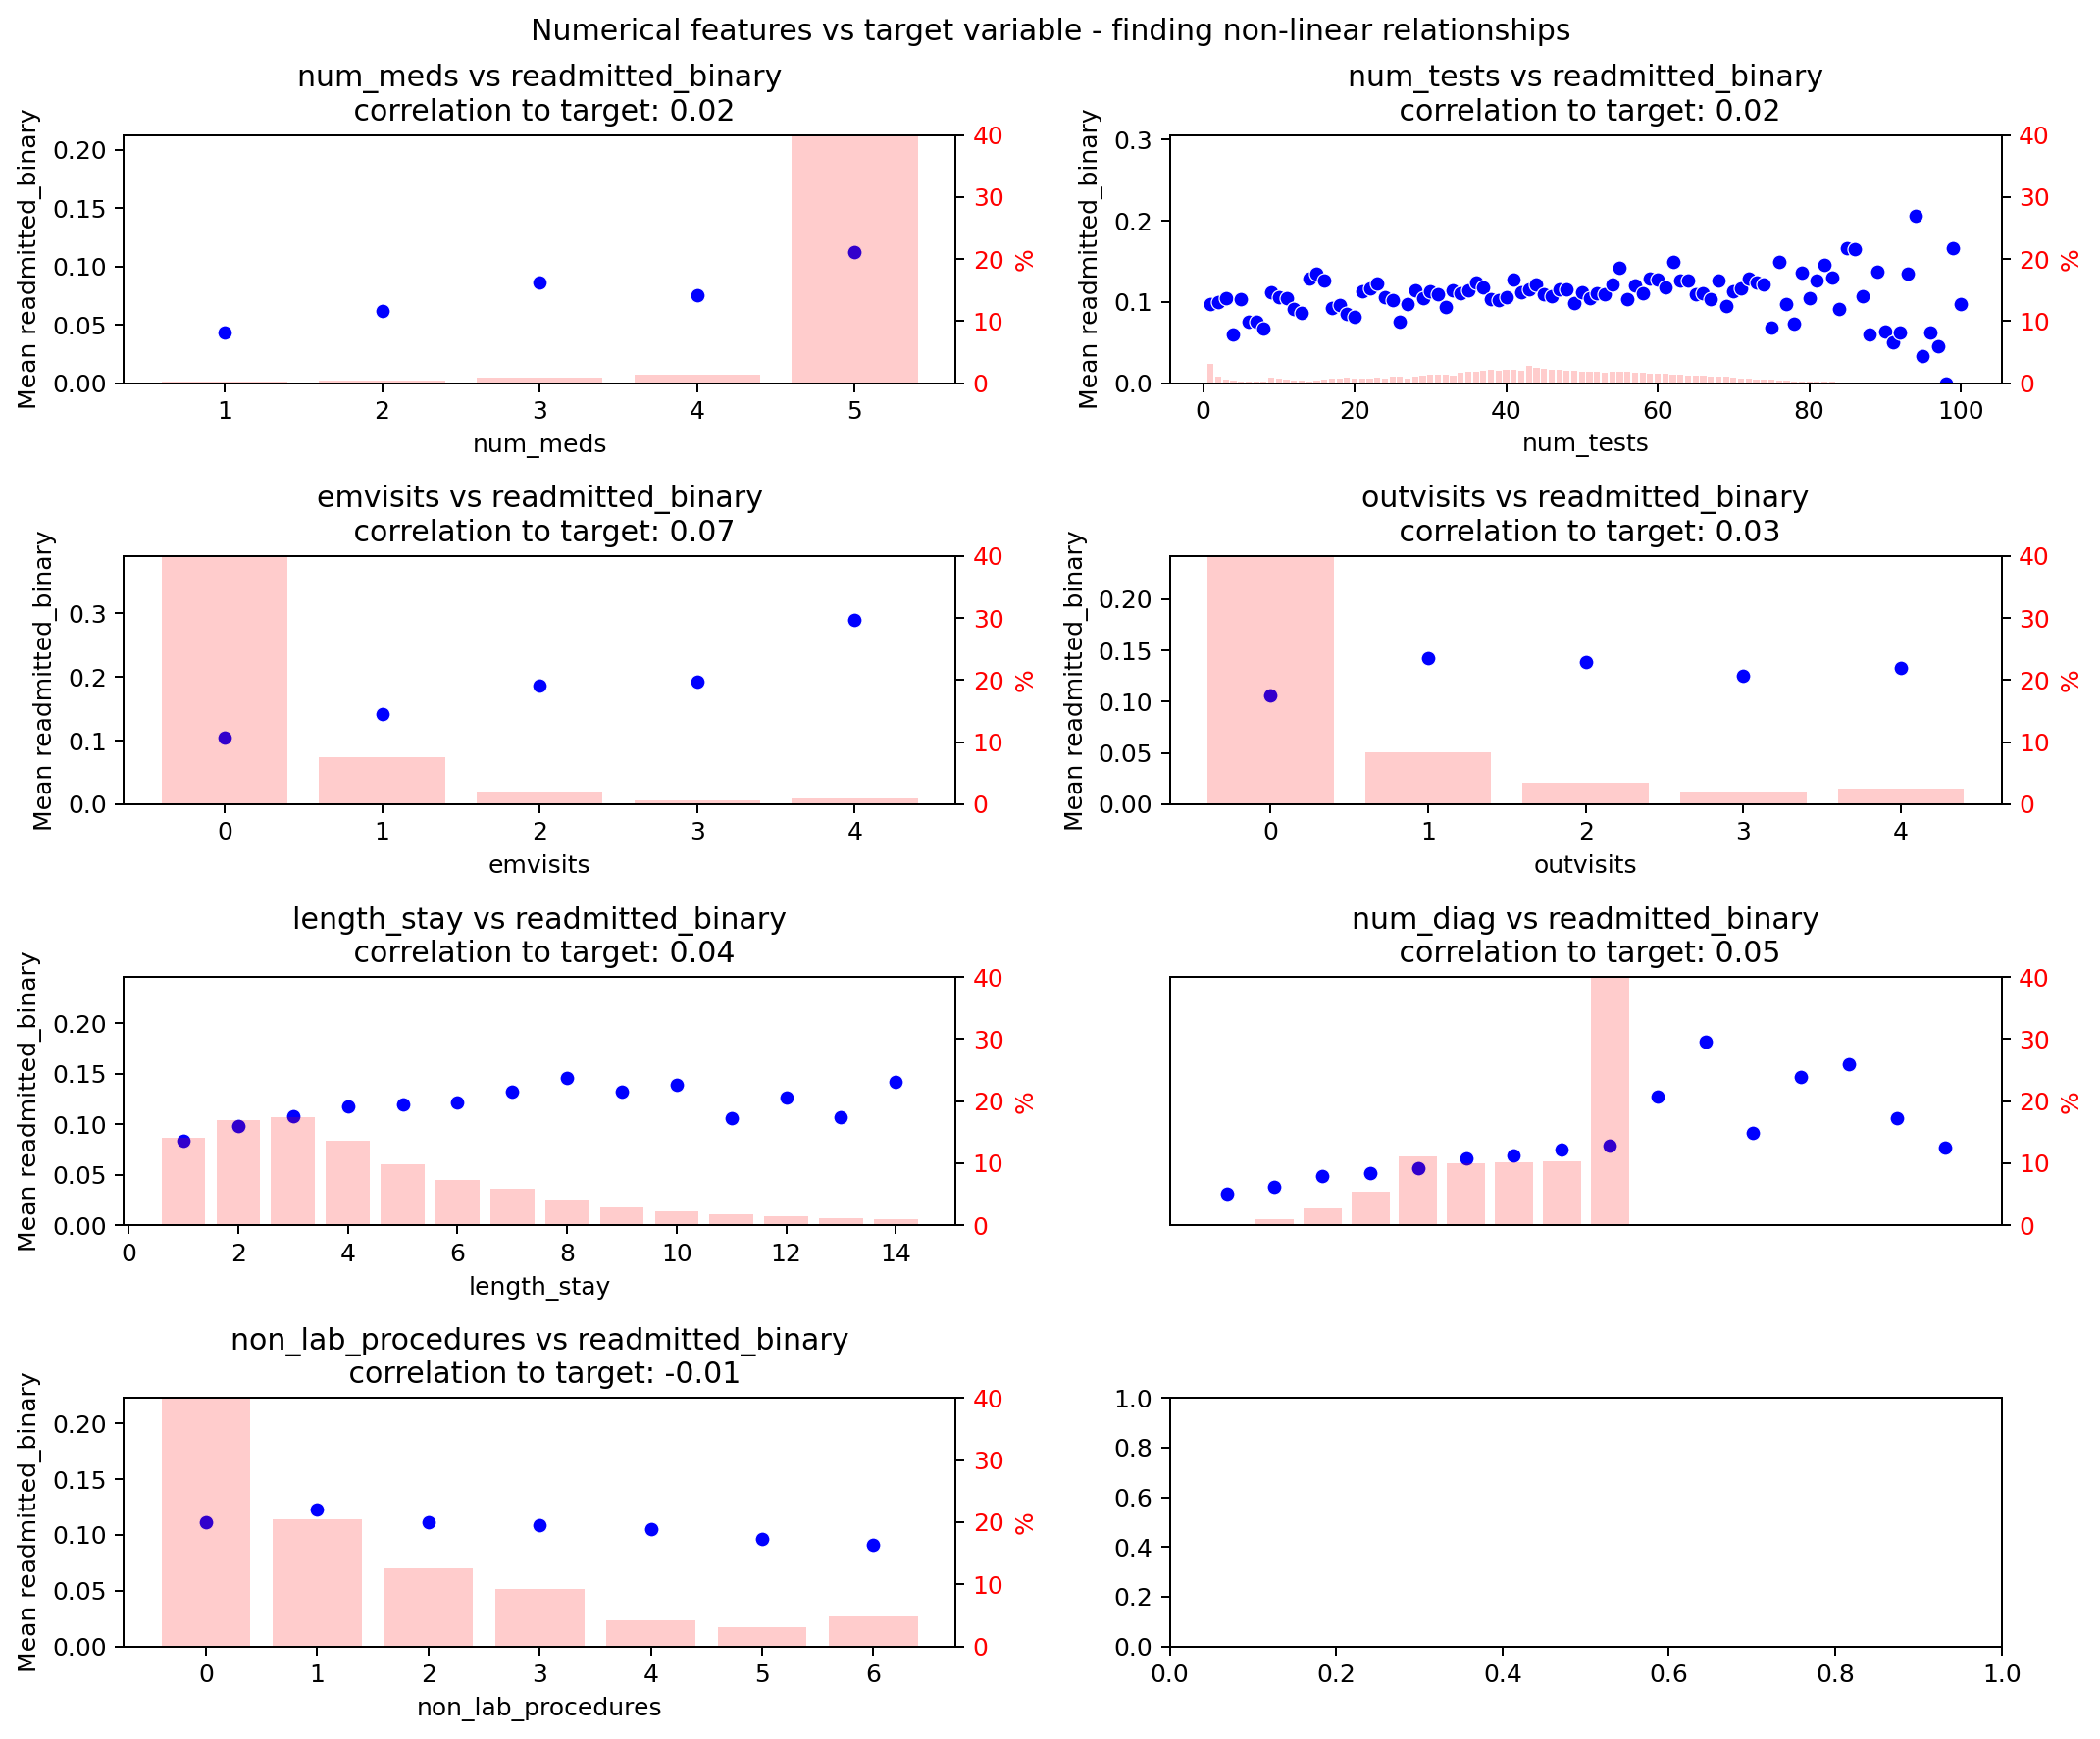

In [87]:
# Lets plot the relationship between the numerical values and the target variable
fig, axes = plt.subplots(4, 2, figsize=(12, 10), dpi=180)

for i, feature in enumerate(set(numerical_features) - set(['sum_visits', 'invisits'])):
    # We want the mean of the target variable for each value of the feature
    to_plot = train.groupby(feature)['readmitted_binary'].mean()
    correlation = train[feature].corr(train['readmitted_binary'])
    sns.scatterplot(x=to_plot.index, y=to_plot.values, color='b', ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{feature} vs readmitted_binary\n correlation to target: {round(correlation, 2)}')
    axes[i//2, i%2].set_xlabel(feature)
    axes[i//2, i%2].set_ylabel('Mean readmitted_binary')
    axes[i//2, i%2].set_ylim(0, max(to_plot.values)+0.1)
    # Plot the count of each value in the feature
    ax2 = axes[i//2, i%2].twinx()
    ax2.bar(to_plot.index, 100*train.groupby(feature)['readmitted_binary'].count()/len(train), alpha=0.2, color='r')
    ax2.grid(False)
    ax2.set_ylabel('%', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(0, 40)

# Delete the last axis
axes[2,1].axis('off')
fig.suptitle('Numerical features vs target variable - finding non-linear relationships')
plt.tight_layout()
plt.show()

##### __2. Categorical features__
- "diagnosis" features
- "age" feature
- "disposition" feature
- "admission_source" feature

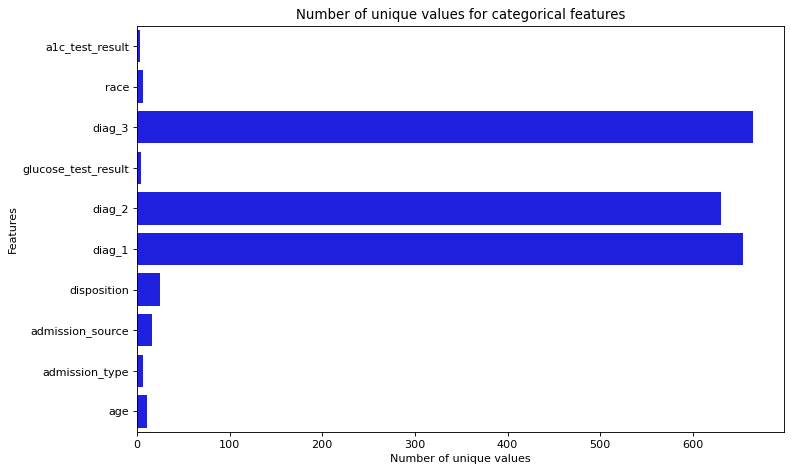

In [88]:
plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=train[categorical_features].nunique().values, y=train[categorical_features].nunique().index, color='b')
plt.title('Number of unique values for categorical features')
plt.xlabel('Number of unique values')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

__Diagnosis feaures:__ Let's reduce the dimensionality of the diagnosis codes by grouping them into their respective disease categories. We will use wikipedia's page [https://en.wikipedia.org/wiki/List_of_ICD-9_codes] to do so.

In [89]:
# First lets transform the diag features into int type
train['diag_1'] = train['diag_1'].apply(lambda x: int(float(x)) if x[0] not in ['E', 'V', 'N'] else x[0])
train['diag_2'] = train['diag_2'].apply(lambda x: int(float(x)) if x[0] not in ['E', 'V', 'N'] else x[0])
train['diag_3'] = train['diag_3'].apply(lambda x: int(float(x)) if x[0] not in ['E', 'V', 'N'] else x[0])

Before completely changing the variable, let-s create a variable "is_diabetic" that will have a binary value ("1" if the patient has been diagnosed with diabetes, and "0" otherwise).

In [90]:
train['is_diabetic'] = ((train['diag_1'].isin(['249','250'])) | (train['diag_2'].isin(['249','250'])) | (train['diag_3'].isin(['249','250']))).apply(lambda x: 1 if x else 0)

In [91]:
# Lets reduce the dimensionality of the diagnosis codes
diag_map = {
    range(1, 140) : 1,
    range(140, 240) : 2,
    range(240, 280) : 3,
    range(280, 290) : 4,
    range(290, 320) : 5,
    range(320, 390) : 6,
    range(390, 460) : 7,
    range(460, 520) : 8,
    range(520, 580) : 9,
    range(580, 630) : 10,
    range(630, 680) : 11,
    range(680, 710) : 12,
    range(710, 740) : 13,
    range(740, 760) : 14,
    range(760, 780) : 15,   
    range(780, 800) : 16,
    range(800, 1000) : 17,
    'E' : 18,
    'V' : 18, 
    'N' : -1
}

for i in range(1, 4):
    train[f'diag_{i}'] = train[f'diag_{i}'].apply(lambda x: next((v for k, v in diag_map.items() if x in k), x))

In [92]:
#diag_description_remap = {
    #1 : 'Infectious and Parasitic Diseases',
    #2 : 'Neoplasms',
    #3 : 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders',
    #4 : 'Diseases of the Blood and Blood-forming Organs',
    #5 : 'Mental Disorders',
    #6 : 'Diseases of the Nervous System and Sense Organs',
    #7 : 'Diseases of the Circulatory System',
    #8 : 'Diseases of the Respiratory System',
    #9 : 'Diseases of the Digestive System',
    #10 : 'Diseases of the Genitourinary System',
    #11 : 'Complications of Pregnancy, Childbirth, and the Puerperium',
    #12 : 'Diseases of the Skin and Subcutaneous Tissue',
    #13 : 'Diseases of the Musculoskeletal System and Connective Tissue',
    #14 : 'Congenital Anomalies',
    #15 : 'Certain Conditions originating in the Perinatal Period',
    #16 : 'Symptoms, Signs and Ill-defined Conditions',
    #17 : 'Injury and Poisoning',
    #18 : 'External Causes of Injury and Supplemental Classification',
    #-1 : 'No Diagnosis'
#}

#for i in range(1, 4):
    #train[f'diag_{i}_description'] = train[f'diag_{i}'].map(diag_description_remap)

In [93]:
def merge_small_groups(train, list_featrues, threshold=150):
    # For feature values that have less than threshold values, we will replace with the value with the nearest mean value
    for feature in list_featrues:
        to_replace = train[feature].value_counts()
        to_replace = to_replace[to_replace < threshold].index.to_list()
        if to_replace == []:
            continue
        for value in to_replace:
            # Find the nearest value that has more than threshold values
            means = train.groupby(feature)['readmitted_binary'].mean().sort_values(ascending=False)
            target_mean = means.loc[value]
            means = means[means.index.isin(to_replace) == False]  # exclude values with less than 100 counts
            nearest_value = (means - target_mean).abs().idxmin()  # find the nearest value
            # Replace the value
            train.loc[train[feature] == value, feature] = nearest_value

merge_small_groups(train, ['diag_1', 'diag_2', 'diag_3'], threshold=150)

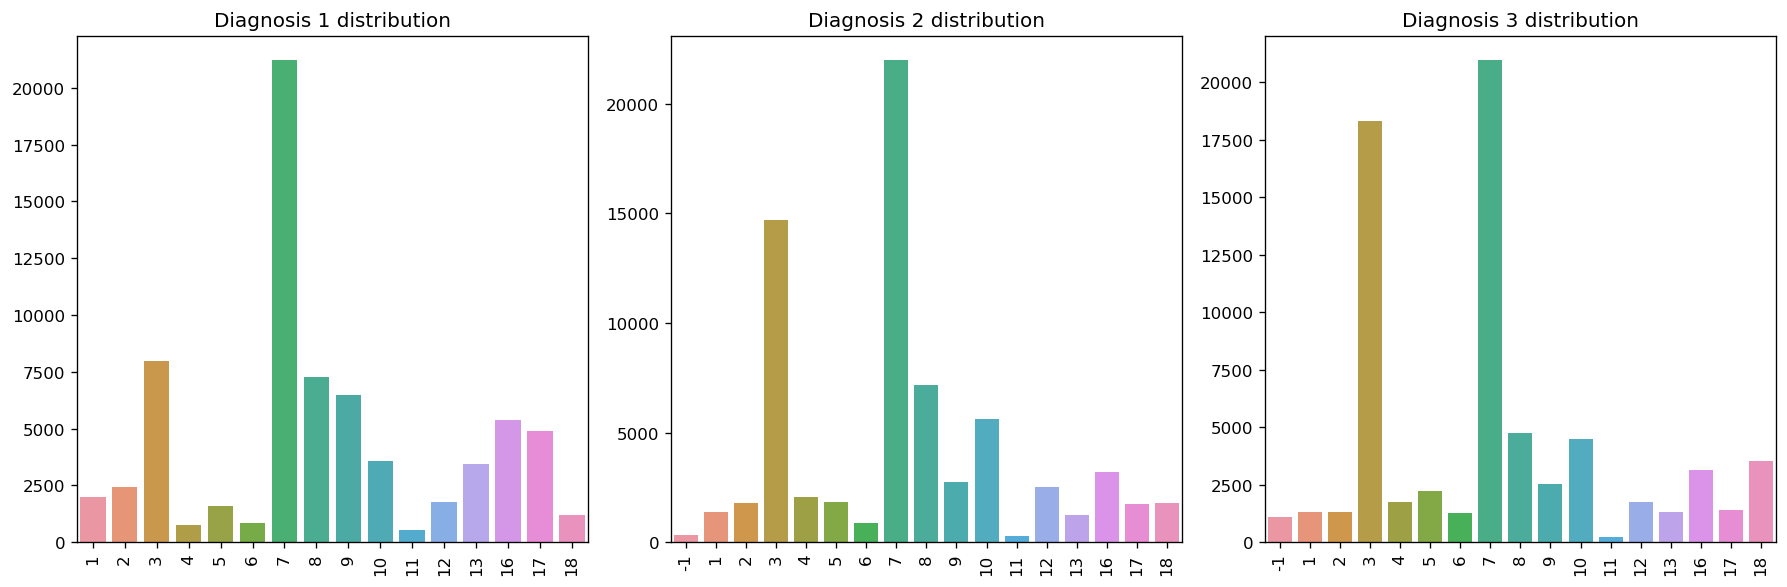

In [94]:
# Lets plot the distribution of the diagnosis codes
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=120)

for i in range(1, 4):
    sns.countplot(x=f'diag_{i}', data=train, ax=axes[i-1])
    axes[i-1].set_title(f'Diagnosis {i} distribution')
    axes[i-1].set_xlabel('')
    axes[i-1].set_ylabel('')
    axes[i-1].set_xticklabels(axes[i-1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

__Age:__ We dont want age to lose its ordinality, but lets change its encoding to a more intuitive one

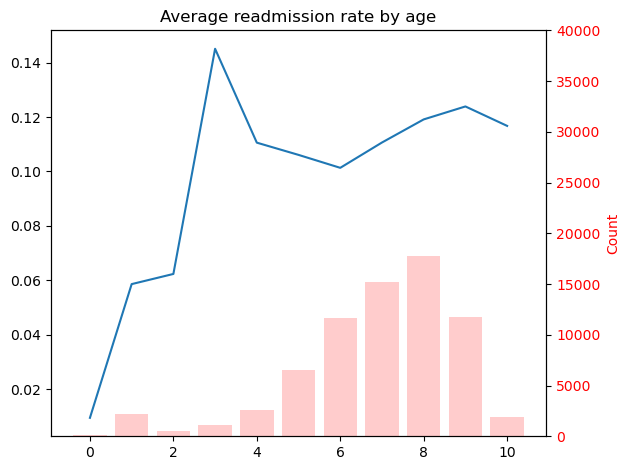

In [95]:
le_age = LabelEncoder()
#train.drop('age', axis=1, inplace=True)

train['age'] = train['age'].astype(int)
train['age'] = le_age.fit_transform(train['age'])

plt.plot(train.groupby('age')['readmitted_binary'].mean())
ax2 = plt.twinx()
ax2.bar(train.groupby('age')['readmitted_binary'].mean().index, train.groupby('age')['readmitted_binary'].count(), alpha=0.2, color='r')
ax2.grid(False)
ax2.set_ylabel('Count', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 40000)
plt.title('Average readmission rate by age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

There could be non-linear relationships between the target variable and this feature ("age"), so let's create a new feature that is the square of age.

In [96]:
train['age_sq'] = train['age']**2

__Disposition:__

In [97]:
grouping = train.groupby('disposition')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
grouping

,mean,count
disposition,,
0.0,0.538462,13
24.0,0.500000,2
14.0,0.397959,98
12.0,0.386364,44
7.0,0.278536,1393
9.0,0.209246,822
8.0,0.165323,1488
6.0,0.156250,32
21.0,0.147268,421


In [98]:
# There are many categories that seem irrelevant, so let's group them (expired, hospice, and very low-frequency categories)
to_group = [18,24,22,4,17,13,15,16,19]
train['disposition'] = train['disposition'].apply(lambda x: 4 if x in to_group else x)
train['disposition'] = train['disposition'].astype(int)

In [99]:
grouping = train.groupby('disposition')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
grouping['desc'] = encoder_dict['disposition'].inverse_transform(grouping.index)
grouping

,mean,count,desc
disposition,,,
0,0.538462,13,Admitted as an inpatient to this hospital
14,0.397959,98,Discharged/transferred/referred to a psychiatr...
12,0.386364,44,Discharged/transferred within this institution...
7,0.278536,1393,Discharged/transferred to another rehab fac in...
9,0.209246,822,Discharged/transferred to another type of inpa...
8,0.165323,1488,Discharged/transferred to another short term h...
6,0.156250,32,Discharged/transferred to a nursing facility c...
21,0.147268,421,Left AMA
3,0.146217,9780,Discharged/transferred to SNF


In [100]:
# Now for the discharged home 
to_group = [10,2,11]
train['disposition'] = train['disposition'].apply(lambda x: 11 if x in to_group else x)

# And for two groups that are very similar in terms of readmission rate
to_group = [8,6]
train['disposition'] = train['disposition'].apply(lambda x: 6 if x in to_group else x)
to_group = [21,3]
train['disposition'] = train['disposition'].apply(lambda x: 21 if x in to_group else x)

In [101]:
merge_small_groups(train, ['disposition'], threshold=150)

In [102]:
grouping = train.groupby('disposition')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
grouping

,mean,count
disposition,,
7,0.291344,1548
9,0.209246,822
6,0.165132,1520
21,0.146260,10201
11,0.126562,12247
23,0.097202,679
1,0.092744,42256
5,0.075000,280
20,0.061303,261


__Admission source:__

In [103]:
grouping = train.groupby('admission_source')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
grouping['desc'] = encoder_dict['admission_source'].inverse_transform(grouping.index)
grouping

,mean,count,desc
admission_source,,,
0,0.181818,11,Court/Law Enforcement
13,0.155039,129,HMO Referral
4,0.140187,107,Not Mapped
8,0.127731,595,Transfer from a Skilled Nursing Facility (SNF)
11,0.125000,8,Transfer from hospital inpt/same fac reslt in...
1,0.116620,40319,Emergency Room
3,0.106325,4806,Not Available
12,0.105263,779,Clinic Referral
5,0.105184,20678,Physician Referral


In [104]:
# Lets create a group just for newborns
to_group = [2,6,7,10,14]
train['admission_source'] = train['admission_source'].apply(lambda x: 14 if x in to_group else x)

# Transfers from health care facilities with similar readmission rates
to_group = [15,9]
train['admission_source'] = train['admission_source'].apply(lambda x: 15 if x in to_group else x)

# Referrals from health care facilities with similar readmission rates
to_group = [12,5]
train['admission_source'] = train['admission_source'].apply(lambda x: 12 if x in to_group else x)

# Other transfers 
to_group = [8,11]
train['admission_source'] = train['admission_source'].apply(lambda x: 8 if x in to_group else x)

In [105]:
merge_small_groups(train, ['admission_source'], threshold=150)

In [106]:
### ESTRANHO ####
train.groupby('admission_source')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
admission_source,,
8,0.134118,850
1,0.116620,40319
3,0.106325,4806
12,0.105187,21457
15,0.096215,3804


__Admission type:__

In [107]:
grouping = train.groupby('admission_type')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
grouping['desc'] = encoder_dict['admission_type'].inverse_transform(grouping.index)
grouping

,mean,count,desc
admission_type,,,
1,0.114938,37742,Emergency
6,0.112101,13024,Urgent
3,0.108312,7026,Not Available
0,0.103853,13211,Elective
4,0.088785,214,Not Mapped
2,0.000000,6,Newborn
5,0.000000,13,Trauma Center


In [108]:
to_group = [3,4]
train['admission_type'] = train['admission_type'].apply(lambda x: 3 if x in to_group else x)

In [109]:
merge_small_groups(train, ['admission_type'], threshold=150)

__Filtering the dataframe:__

Let's check the results:

In [110]:
categorical_features

['a1c_test_result',
 'race',
 'diag_3',
 'glucose_test_result',
 'diag_2',
 'diag_1',
 'disposition',
 'admission_source',
 'admission_type',
 'age']

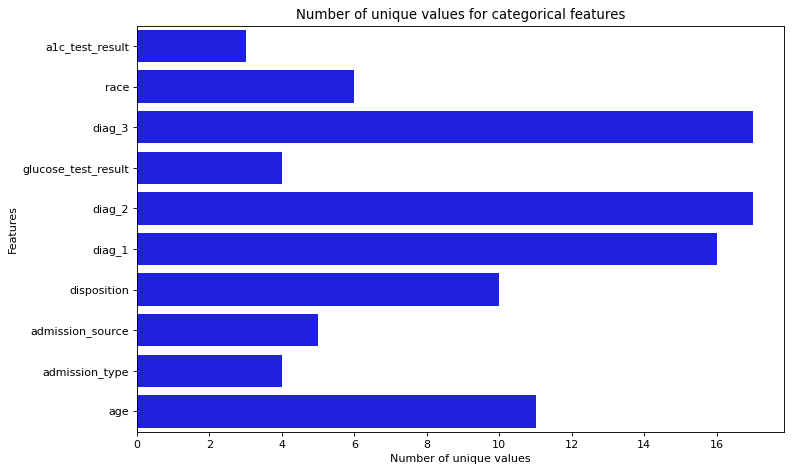

In [111]:
plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=train[categorical_features].nunique().values, y=train[categorical_features].nunique().index, color='b')
plt.title('Number of unique values for categorical features')
plt.xlabel('Number of unique values')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [112]:
numerical_features

['num_meds',
 'num_tests',
 'emvisits',
 'outvisits',
 'length_stay',
 'invisits',
 'num_diag',
 'non_lab_procedures']

### __VI. Data Preprocessing in the Test Data__

Here, we will be applying the same data preprocessing and feature engineering steps, adjusted to the test dataset. 

In [113]:
test

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,average_pulse_bpm,discharge_disposition,admission_source,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
499502,USA,103232799,Caucasian,Male,[80-90),?,HM,0,0,0,Emergency,?,139,Discharged to home,Emergency Room,3,48,0,14,491,414,250,6,NaN,NaN,No,Yes,['metformin']
447319,USA,93395304,Caucasian,Male,[20-30),?,HM,0,0,1,Emergency,?,103,Discharged to home,Emergency Room,10,77,1,7,250.13,70,794,7,>300,NaN,No,No,[]
309126,USA,6281586,AfricanAmerican,Male,[30-40),?,?,0,0,0,Emergency,Pulmonology,99,Discharged to home,Emergency Room,2,44,3,12,786,250.6,536,6,NaN,NaN,No,Yes,['insulin']
181183,USA,67381308,Caucasian,Male,[50-60),?,BC,0,0,0,Not Available,?,136,Discharged to home,Emergency Room,4,48,1,16,820,873,E884,9,NaN,NaN,Ch,Yes,"['metformin', 'glyburide', 'insulin']"
359339,USA,71670204,Caucasian,Male,[60-70),?,?,0,0,0,Emergency,InternalMedicine,137,Discharged to home,Emergency Room,1,43,0,10,599,427,414,9,NaN,NaN,No,Yes,['metformin']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451150,USA,85707450,Caucasian,Male,[70-80),?,HM,0,0,0,Emergency,?,133,Discharged/transferred to SNF,Emergency Room,4,51,0,11,584,276,276,9,NaN,NaN,No,No,[]
549298,USA,328887,Caucasian,Male,[60-70),?,?,0,0,4,Emergency,Family/GeneralPractice,62,Discharged to home,Emergency Room,2,49,0,19,428,250.83,276,9,NaN,NaN,No,Yes,['insulin']
327586,USA,21915459,Caucasian,Female,[80-90),?,?,0,0,0,Emergency,Nephrology,121,Discharged/transferred to SNF,Emergency Room,2,32,3,22,996,403,250,6,NaN,NaN,No,Yes,['insulin']


0. Dropping the 'country' feature, as we already saw it is only an informative feature.

In [114]:
test.drop('country', axis=1, inplace=True)

1. Dropping the "gender" feature, according to the result of the chi-squared test performed on the train dataset.

In [115]:
# We, therefore drop the gender column
gender = test['gender']
test.drop('gender', axis=1, inplace=True)

In [116]:
mapper = {
    'outpatient_visits_in_previous_year': 'outvisits',
    'inpatient_visits_in_previous_year': 'invisits',
    'emergency_visits_in_previous_year': 'emvisits',
    'change_in_meds_during_hospitalization': 'change_meds',
    'prescribed_diabetes_meds': 'diabetes_meds',
    'length_of_stay_in_hospital': 'length_stay',
    'number_of_medications': 'num_meds',
    'primary_diagnosis': 'diag_1',
    'secondary_diagnosis': 'diag_2',
    'additional_diagnosis': 'diag_3',
    'number_diagnoses': 'num_diag',
    'number_lab_tests': 'num_tests',
    'discharge_disposition': 'disposition'
}

test.rename(columns=mapper, inplace=True)

In [117]:
test['diag_1'] = test['diag_1'].apply(lambda x: '0' + x if len(x) == 2 else x)
test['diag_1'] = test['diag_1'].apply(lambda x: '00' + x if len(x) == 1 and x!='?' else x)
test['diag_1'] = test['diag_1'].apply(lambda x: x if len(x) == 3 else x[:3])
test['diag_2'] = test['diag_2'].apply(lambda x: '0' + x if len(x) == 2 else x)
test['diag_2'] = test['diag_2'].apply(lambda x: '00' + x if len(x) == 1 and x != '?' else x)
test['diag_2'] = test['diag_2'].apply(lambda x: x if len(x) == 3 else x[:3])
test['diag_3'] = test['diag_3'].apply(lambda x: '0' + x if len(x) == 2 else x)
test['diag_3'] = test['diag_3'].apply(lambda x: '00' + x if len(x) == 1 and x != '?' else x)
test['diag_3'] = test['diag_3'].apply(lambda x: x if len(x) == 3 else x[:3])

In [118]:
test['diabetes_meds'] = test['diabetes_meds'].map({'No': 0, 'Yes': 1})
test['change_meds'] = test['change_meds'].map({'No': 0, 'Ch': 1})

In [119]:
print('Features with ? : ', test.columns[test.isin(['?']).any()].tolist())

test.replace('?', np.nan, inplace=True)

Features with ? :  ['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']


In [120]:
test['admission_type'] = test['admission_type'].fillna('Not Available')
test['admission_source'] = test['admission_source'].fillna(' Not Available')

In [121]:
# Encode the following variables: race, payer_code, admission_type, medical_specialty, discharge_disposition, admission_source
features_to_encode = ['race', 'payer_code', 'admission_type', 'medical_specialty', 'disposition', 'admission_source']
encoder_dict = {features_to_encode[i]: LabelEncoder() for i in range(len(features_to_encode))}
for feature in features_to_encode:
    encoder_dict[feature].fit(test[feature])
    test[feature] = encoder_dict[feature].transform(test[feature].values)
    # Convert the class of Nan to Nan, which is always the last for classes that are not admission_type and admission_source
    if feature not in ['admission_type', 'admission_source']:
        test[feature].replace(encoder_dict[feature].transform(encoder_dict[feature].classes_)[-1], np.nan, inplace=True)
    print(f'{feature} classes: ', dict(zip(encoder_dict[feature].classes_, encoder_dict[feature].transform(encoder_dict[feature].classes_))))

race classes:  {'AfricanAmerican': 0, 'Asian': 1, 'Caucasian': 2, 'Hispanic': 3, 'Other': 4, nan: 5}
payer_code classes:  {'BC': 0, 'CH': 1, 'CM': 2, 'CP': 3, 'DM': 4, 'HM': 5, 'MC': 6, 'MD': 7, 'MP': 8, 'OG': 9, 'OT': 10, 'PO': 11, 'SI': 12, 'SP': 13, 'UN': 14, 'WC': 15, nan: 16}
admission_type classes:  {'Elective': 0, 'Emergency': 1, 'Newborn': 2, 'Not Available': 3, 'Not Mapped': 4, 'Trauma Center': 5, 'Urgent': 6}
medical_specialty classes:  {'AllergyandImmunology': 0, 'Anesthesiology': 1, 'Anesthesiology-Pediatric': 2, 'Cardiology': 3, 'Cardiology-Pediatric': 4, 'DCPTEAM': 5, 'Dermatology': 6, 'Emergency/Trauma': 7, 'Endocrinology': 8, 'Endocrinology-Metabolism': 9, 'Family/GeneralPractice': 10, 'Gastroenterology': 11, 'Gynecology': 12, 'Hematology': 13, 'Hematology/Oncology': 14, 'Hospitalist': 15, 'InfectiousDiseases': 16, 'InternalMedicine': 17, 'Nephrology': 18, 'Neurology': 19, 'Obsterics&Gynecology-GynecologicOnco': 20, 'Obstetrics': 21, 'ObstetricsandGynecology': 22, 'Onco

In [122]:
test['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}, inplace=True)
test['weight'].replace({'[0-25)': 12.5, '[25-50)': 37.5, '[50-75)': 62.5, '[75-100)': 87.5, '[100-125)': 112.5, '[125-150)': 137.5, '[150-175)': 162.5, '[175-200)': 187.5, '>200': 225}, inplace=True)

In [123]:
# Transforming the medication list into many dummy variables
t_meds = test['medication'].str.get_dummies(sep=',')

# Remove any symbols from the column names
to_remove = ['[', ']', "'", ' ']
for symbol in to_remove:
    t_meds.columns = t_meds.columns.str.replace(symbol, '', regex=True)

In [124]:
unique_cols = t_meds.columns.unique()
new_t_meds = pd.DataFrame(columns=unique_cols)
for col in unique_cols:
    if type(t_meds[col]) == pd.Series:
        new_t_meds[col] = t_meds[col]
    else:
        new_t_meds[col] = t_meds[col].max(axis=1)
t_meds = new_t_meds

# Lets delete combinations of drugs
for col in t_meds.columns.unique():
    if '-' in col:
        t_meds.drop(col, axis=1, inplace=True)
        
# Rename the last column to avoid confusion
t_meds.rename(columns={'' : 'no_meds'}, inplace=True)

t_meds.head()

,acarbose,chlorpropamide,glimepiride,glipizide,glyburide,insulin,miglitol,nateglinide,pioglitazone,repaglinide,rosiglitazone,tolazamide,troglitazone,metformin,tolbutamide,no_meds
encounter_id,,,,,,,,,,,,,,,,
499502,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
447319,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
309126,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
181183,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
359339,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [125]:
test = pd.concat([test, t_meds], axis=1)
# Deleting the medication column
test.drop('medication', axis=1, inplace=True)

In [126]:
test_II = test.copy()
t_numerical_features = ['age', 'weight', 'outvisits', 'emvisits', 'invisits', 'average_pulse_bpm', 'length_stay', 'num_tests', 'non_lab_procedures', 'num_meds', 'num_diag']
t_binary_features = ['change_meds', 'diabetes_meds', 'no_meds', 'acarbose', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'insulin', 'miglitol', 'nateglinide', 'pioglitazone', 'repaglinide', 'rosiglitazone', 'tolazamide', 'troglitazone', 'metformin', 'tolbutamide']
t_categorical_features = set(test.columns) - set(numerical_features) - set(binary_features) - set(['readmitted_binary', 'readmitted_multiclass', 'patient_id'])

In [127]:
test_II

,patient_id,race,age,weight,payer_code,outvisits,emvisits,invisits,admission_type,medical_specialty,average_pulse_bpm,disposition,admission_source,length_stay,num_tests,non_lab_procedures,num_meds,diag_1,diag_2,diag_3,num_diag,glucose_test_result,a1c_test_result,change_meds,diabetes_meds,acarbose,chlorpropamide,glimepiride,glipizide,glyburide,insulin,miglitol,nateglinide,pioglitazone,repaglinide,rosiglitazone,tolazamide,troglitazone,metformin,tolbutamide,no_meds
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
499502,103232799,2.0,85.0,NaN,5.0,0,0,0,1,NaN,139,1.0,1,3,48,0,14,491,414,250,6,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
447319,93395304,2.0,25.0,NaN,5.0,0,0,1,1,NaN,103,1.0,1,10,77,1,7,250,070,794,7,>300,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
309126,6281586,0.0,35.0,NaN,NaN,0,0,0,1,46.0,99,1.0,1,2,44,3,12,786,250,536,6,NaN,NaN,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
181183,67381308,2.0,55.0,NaN,0.0,0,0,0,3,NaN,136,1.0,1,4,48,1,16,820,873,E88,9,NaN,NaN,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
359339,71670204,2.0,65.0,NaN,NaN,0,0,0,1,17.0,137,1.0,1,1,43,0,10,599,427,414,9,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451150,85707450,2.0,75.0,NaN,5.0,0,0,0,1,NaN,133,3.0,1,4,51,0,11,584,276,276,9,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
549298,328887,2.0,65.0,NaN,NaN,0,0,4,1,10.0,62,1.0,1,2,49,0,19,428,250,276,9,NaN,NaN,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
327586,21915459,2.0,85.0,NaN,NaN,0,0,0,1,18.0,121,3.0,1,2,32,3,22,996,403,250,6,NaN,NaN,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [128]:
average_pulse_bpm = test['average_pulse_bpm']
test = test.drop(['average_pulse_bpm'], axis=1)

In [129]:
#ver se aplicar isto ao test não enviesa - devemos aplicar os resultados disto ao test só
t_binary_features = test[t_binary_features]
t_binary_features = t_binary_features.apply(lambda x: x.value_counts(normalize=True), axis=0)
t_binary_features = t_binary_features.T
t_binary_features['entropy'] = t_binary_features.apply(lambda x: -np.sum(x*np.log2(x)), axis=1)
t_binary_features.sort_values(by='entropy', inplace=True, ascending=False)

to_remove = list(set(t_binary_features[t_binary_features['entropy'] < 0.1].index.tolist()))
test.drop(to_remove, axis=1, inplace=True, errors='ignore')
t_binary_features.drop(to_remove, axis=0, inplace=True)

In [130]:
test.drop('glipizide', axis=1, inplace=True)

In [131]:
test

,patient_id,race,age,weight,payer_code,outvisits,emvisits,invisits,admission_type,medical_specialty,disposition,admission_source,length_stay,num_tests,non_lab_procedures,num_meds,diag_1,diag_2,diag_3,num_diag,glucose_test_result,a1c_test_result,change_meds,diabetes_meds,glimepiride,glyburide,insulin,pioglitazone,repaglinide,rosiglitazone,metformin,no_meds
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
499502,103232799,2.0,85.0,NaN,5.0,0,0,0,1,NaN,1.0,1,3,48,0,14,491,414,250,6,NaN,NaN,0,1,0,0,0,0,0,0,1,0
447319,93395304,2.0,25.0,NaN,5.0,0,0,1,1,NaN,1.0,1,10,77,1,7,250,070,794,7,>300,NaN,0,0,0,0,0,0,0,0,0,1
309126,6281586,0.0,35.0,NaN,NaN,0,0,0,1,46.0,1.0,1,2,44,3,12,786,250,536,6,NaN,NaN,0,1,0,0,1,0,0,0,0,0
181183,67381308,2.0,55.0,NaN,0.0,0,0,0,3,NaN,1.0,1,4,48,1,16,820,873,E88,9,NaN,NaN,1,1,0,1,1,0,0,0,1,0
359339,71670204,2.0,65.0,NaN,NaN,0,0,0,1,17.0,1.0,1,1,43,0,10,599,427,414,9,NaN,NaN,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451150,85707450,2.0,75.0,NaN,5.0,0,0,0,1,NaN,3.0,1,4,51,0,11,584,276,276,9,NaN,NaN,0,0,0,0,0,0,0,0,0,1
549298,328887,2.0,65.0,NaN,NaN,0,0,4,1,10.0,1.0,1,2,49,0,19,428,250,276,9,NaN,NaN,0,1,0,0,1,0,0,0,0,0
327586,21915459,2.0,85.0,NaN,NaN,0,0,0,1,18.0,3.0,1,2,32,3,22,996,403,250,6,NaN,NaN,0,1,0,0,1,0,0,0,0,0


In [132]:
test_III = test.copy()

In [133]:
glucose_map = {'Norm': 'Normal', '>200': 'Probably diabetic', '>300': 'Diabetic'}
a1c_map = {'Norm': 'Normal', '>7': 'Diabetic', '>8': 'Diabetic'}
test['glucose_test_result'] = test['glucose_test_result'].map(glucose_map).fillna('Not tested')
test['a1c_test_result'] = test['a1c_test_result'].map(a1c_map).fillna('Not tested')
print(test['glucose_test_result'].value_counts(), '\n')
print(test['a1c_test_result'].value_counts())

Not tested           28872
Normal                 791
Diabetic               437
Probably diabetic      430
Name: glucose_test_result, dtype: int64 

Not tested    25428
Diabetic       3615
Normal         1487
Name: a1c_test_result, dtype: int64


In [134]:
test['payer_code'].fillna("-1", inplace=True)

# For counts below 1% we will replace with 'Other'
providor_proportion = test['payer_code'].value_counts(normalize=True)
change = providor_proportion[providor_proportion < 0.01].index
test['payer_code'] = test['payer_code'].replace(change, 99)

In [135]:
weight = test['weight']
medical_specialty = test['medical_specialty']
test = test.drop(['weight', 'medical_specialty'], axis=1, errors='ignore')
t_categorical_features = list(set(t_categorical_features) - set(['medical_specialty']))

In [136]:
ids_race_missing = test[test['race'].isna()]['patient_id'].unique()
test_race = test[test['race'].notna()]
intersect = test_race[test_race['patient_id'].isin(ids_race_missing)]

# From those, there are repeated patient_ids, so lets check how many unique patient_ids there are
print('Unique patient_ids: ', len(intersect['patient_id'].unique()))
print('Total patient_ids missing: ', len(ids_race_missing))

Unique patient_ids:  353
Total patient_ids missing:  2135


In [137]:
missingRace = test[test['race'].isna()]
missingRace = missingRace[missingRace['patient_id'].isin(intersect['patient_id'].unique())]

# Let's now fill the ids_missing with the first patient id value that is not missing
patient_race_mapping = test_race.groupby('patient_id')['race'].first()
mapper = missingRace.apply(lambda row: patient_race_mapping[row['patient_id']] if pd.isna(row['race']) else row['race'], axis=1)

# Now lets fill the missing values
test.loc[mapper.index, 'race'] = mapper

In [138]:
test['race'].fillna('Not Registered', inplace=True)

In [139]:
ids_age_missing = test[test['age'].isna()]['patient_id'].unique()
test_age = test[test['age'].notna()]
intersect = test_age[test_age['patient_id'].isin(ids_age_missing)]

# From those, there are repeated patient_ids, so lets check how many unique patient_ids there are
print('Unique patient_ids: ', len(intersect['patient_id'].unique()))
print('Total patient_ids missing: ', len(ids_age_missing))

Unique patient_ids:  328
Total patient_ids missing:  1517


In [140]:
test['age'].fillna('10', inplace=True)

In [141]:
test['disposition'].fillna(11, inplace=True)

In [142]:
test['diag_1'] = test['diag_1'].fillna('No Diagnosis')
test['diag_2'] = test['diag_2'].fillna('No Diagnosis')
test['diag_3'] = test['diag_3'].fillna('No Diagnosis')

In [143]:
#ids_gender_missing = test[test['gender'].isna()]['patient_id'].unique()
#test_gender = test[test['gender'].notna()]
#intersect = test_gender[test_gender['patient_id'].isin(ids_gender_missing)]

#From those, there are repeated patient_ids, so lets check how many unique patient_ids there are
#print('Unique patient_ids: ', len(intersect['patient_id'].unique()))
#print('Total patient_ids missing: ', len(ids_gender_missing))

In [144]:
#missingGender = test[test['gender'].isna()]
#missingGender = missingGender[missingGender['patient_id'].isin(intersect['patient_id'].unique())]

# Let's now fill the ids_missing with the first patient id value that is not missing
#patient_gender_mapping = test_race.groupby('patient_id')['gender'].first()
#mapper = missingGender.apply(lambda row: patient_gender_mapping[row['patient_id']] if pd.isna(row['gender']) else row['gender'], axis=1)

# Now lets fill the missing values
#test.loc[mapper.index, 'gender'] = mapper

In [145]:
#test['gender'].fillna('Not Registered', inplace=True)

In [146]:
# Lets save a backup of the data
test_IV = test.copy()

In [147]:
# Lets update for the variables we have changed. Age should also be considered a categorical variable
t_numerical_features = list(set(t_numerical_features) - set(['average_pulse_bpm', 'weight', 'age']))
t_categorical_features = list(set(t_categorical_features) - set(['payer_code'])) + ['age']

In [148]:
test['sum_visits'] = test['outvisits'] + test['emvisits'] + test['invisits']
#outvisits, emvisits = train['outvisits'], train['emvisits']
#train.drop(['outvisits', 'emvisits'], axis=1, inplace=True)
#numerical_features = list(set(numerical_features) - set(['outvisits', 'emvisits'])) + ['sum_visits']

In [149]:
t_alpha = 4
t_pure_invisits = test['invisits'].copy()
t_pure_emvisits = test['emvisits'].copy()
t_pure_outvisits = test['outvisits'].copy()
t_pure_visits = test['sum_visits'].copy()

test.loc[test['invisits'] > alpha, 'invisits'] = t_alpha
test.loc[test['outvisits'] > alpha, 'outvisits'] = t_alpha
test.loc[test['emvisits'] > alpha, 'emvisits'] = t_alpha
test.loc[test['sum_visits'] > alpha, 'sum_visits'] = t_alpha

In [150]:
t_beta = 5
t_pure_num_meds = test['num_meds'].copy()
t_pure_num_meds_sq = test['num_meds'].copy() ** 2
test.loc[test['num_meds'] > beta, 'num_meds'] = t_beta
test['num_meds_sq'] = test['num_meds']**2

In [151]:
test['diag_1'] = test['diag_1'].apply(lambda x: int(float(x)) if x[0] not in ['E', 'V', 'N'] else x[0])
test['diag_2'] = test['diag_2'].apply(lambda x: int(float(x)) if x[0] not in ['E', 'V', 'N'] else x[0])
test['diag_3'] = test['diag_3'].apply(lambda x: int(float(x)) if x[0] not in ['E', 'V', 'N'] else x[0])

In [152]:
test['is_diabetic'] = ((test['diag_1'].isin(['249','250'])) | (test['diag_2'].isin(['249','250'])) | (test['diag_3'].isin(['249','250']))).apply(lambda x: 1 if x else 0)

In [153]:
# Lets reduce the dimensionality of the diagnosis codes
diag_map = {
    range(1, 140) : 1,
    range(140, 240) : 2,
    range(240, 280) : 3,
    range(280, 290) : 4,
    range(290, 320) : 5,
    range(320, 390) : 6,
    range(390, 460) : 7,
    range(460, 520) : 8,
    range(520, 580) : 9,
    range(580, 630) : 10,
    range(630, 680) : 11,
    range(680, 710) : 12,
    range(710, 740) : 13,
    range(740, 760) : 14,
    range(760, 780) : 15,   
    range(780, 800) : 16,
    range(800, 1000) : 17,
    'E' : 18,
    'V' : 18, 
    'N' : -1
}

for i in range(1, 4):
    test[f'diag_{i}'] = test[f'diag_{i}'].apply(lambda x: next((v for k, v in diag_map.items() if x in k), x))

In [154]:
#diag_description_remap = {
    #1 : 'Infectious and Parasitic Diseases',
    #2 : 'Neoplasms',
    #3 : 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders',
    #4 : 'Diseases of the Blood and Blood-forming Organs',
    #5 : 'Mental Disorders',
    #6 : 'Diseases of the Nervous System and Sense Organs',
    #7 : 'Diseases of the Circulatory System',
    #8 : 'Diseases of the Respiratory System',
    #9 : 'Diseases of the Digestive System',
    #10 : 'Diseases of the Genitourinary System',
    #11 : 'Complications of Pregnancy, Childbirth, and the Puerperium',
    #12 : 'Diseases of the Skin and Subcutaneous Tissue',
    #13 : 'Diseases of the Musculoskeletal System and Connective Tissue',
    #14 : 'Congenital Anomalies',
    #15 : 'Certain Conditions originating in the Perinatal Period',
    #16 : 'Symptoms, Signs and Ill-defined Conditions',
    #17 : 'Injury and Poisoning',
    #18 : 'External Causes of Injury and Supplemental Classification',
    #-1 : 'No Diagnosis'
#}

#for i in range(1, 4):
    #test[f'diag_{i}_description'] = test[f'diag_{i}'].map(diag_description_remap)

In [155]:
#def merge_small_groups(test, list_features, threshold=150):
    # For feature values that have less than threshold values, we will replace with the value with the nearest mean value
    #for feature in list_features:
        #to_replace = test[feature].value_counts()
        #to_replace = to_replace[to_replace < threshold].index.to_list()
        #if to_replace == []:
            #continue
        #for value in to_replace:
            # Find the nearest value that has more than threshold values
            #means = train.groupby(feature)['readmitted_binary'].mean().sort_values(ascending=False)
            #target_mean = means.loc[value]
            #means = means[means.index.isin(to_replace) == False]  # exclude values with less than 100 counts
            #nearest_value = (means - target_mean).abs().idxmin()  # find the nearest value
            # Replace the value
            #test.loc[test[feature] == value, feature] = nearest_value

#merge_small_groups(test, ['diag_1', 'diag_2', 'diag_3'], threshold=150)

In [156]:
def merge_small_groups(test, list_features, threshold=150):
    for feature in list_features:
        to_replace = test[feature].value_counts()
        to_replace = to_replace[to_replace < threshold].index.to_list()
        if to_replace == []:
            continue
        for value in to_replace:
            means = train.groupby(feature)['readmitted_binary'].mean().sort_values(ascending=False)
            if value not in means.index:
                continue
            target_mean = means.loc[value]
            means = means[means.index.isin(to_replace) == False]
            nearest_value = (means - target_mean).abs().idxmin()
            test.loc[test[feature] == value, feature] = nearest_value

merge_small_groups(test, ['diag_1', 'diag_2', 'diag_3'], threshold=150)

In [157]:
le_age = LabelEncoder()
#test.drop('age', axis=1, inplace=True)

test['age'] = test['age'].astype(int)
test['age'] = le_age.fit_transform(test['age'])

In [158]:
test['age_sq'] = test['age']**2

In [159]:
# There are many categories that seem irrelevant, so let's group them (expired, hospice, and very low-frequency categories)
to_group = [18,24,22,4,17,13,15,16,19]
test['disposition'] = test['disposition'].apply(lambda x: 4 if x in to_group else x)
test['disposition'] = test['disposition'].astype(int)

In [160]:
# Now for the discharged home 
to_group = [10,2,11]
test['disposition'] = test['disposition'].apply(lambda x: 11 if x in to_group else x)

# And for two groups that are very similar in terms of readmission rate
to_group = [8,6]
test['disposition'] = test['disposition'].apply(lambda x: 6 if x in to_group else x)
to_group = [21,3]
test['disposition'] = test['disposition'].apply(lambda x: 21 if x in to_group else x)

In [161]:
merge_small_groups(test, ['disposition'], threshold=150)

In [162]:
# Lets create a group just for newborns
to_group = [2,6,7,10,14]
test['admission_source'] = test['admission_source'].apply(lambda x: 14 if x in to_group else x)

# Transfers from health care facilities with similar readmission rates
to_group = [15,9]
test['admission_source'] = test['admission_source'].apply(lambda x: 15 if x in to_group else x)

# Referrals from health care facilities with similar readmission rates
to_group = [12,5]
test['admission_source'] = test['admission_source'].apply(lambda x: 12 if x in to_group else x)

# Other transfers 
to_group = [8,11]
test['admission_source'] = test['admission_source'].apply(lambda x: 8 if x in to_group else x)

In [163]:
merge_small_groups(test, ['admission_source'], threshold=150)

In [164]:
to_group = [3,4]
test['admission_type'] = test['admission_type'].apply(lambda x: 3 if x in to_group else x)

In [165]:
merge_small_groups(test, ['admission_type'], threshold=150)

In [166]:
test

,patient_id,race,age,payer_code,outvisits,emvisits,invisits,admission_type,disposition,admission_source,length_stay,num_tests,non_lab_procedures,num_meds,diag_1,diag_2,diag_3,num_diag,glucose_test_result,a1c_test_result,change_meds,diabetes_meds,glimepiride,glyburide,insulin,pioglitazone,repaglinide,rosiglitazone,metformin,no_meds,sum_visits,num_meds_sq,is_diabetic,age_sq
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
499502,103232799,2.0,9,5.0,0,0,0,1,1,1,3,48,0,5,8,7,3,6,Not tested,Not tested,0,1,0,0,0,0,0,0,1,0,0,25,0,81
447319,93395304,2.0,3,5.0,0,0,1,1,1,1,10,77,1,5,3,1,16,7,Diabetic,Not tested,0,0,0,0,0,0,0,0,0,1,1,25,0,9
309126,6281586,0.0,4,-1,0,0,0,1,1,1,2,44,3,5,16,3,9,6,Not tested,Not tested,0,1,0,0,1,0,0,0,0,0,0,25,0,16
181183,67381308,2.0,6,0.0,0,0,0,3,1,1,4,48,1,5,17,17,18,9,Not tested,Not tested,1,1,0,1,1,0,0,0,1,0,0,25,0,36
359339,71670204,2.0,7,-1,0,0,0,1,1,1,1,43,0,5,10,7,7,9,Not tested,Not tested,0,1,0,0,0,0,0,0,1,0,0,25,0,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451150,85707450,2.0,8,5.0,0,0,0,1,21,1,4,51,0,5,10,3,3,9,Not tested,Not tested,0,0,0,0,0,0,0,0,0,1,0,25,0,64
549298,328887,2.0,7,-1,0,0,4,1,1,1,2,49,0,5,7,3,3,9,Not tested,Not tested,0,1,0,0,1,0,0,0,0,0,4,25,0,49
327586,21915459,2.0,9,-1,0,0,0,1,21,1,2,32,3,5,17,7,3,6,Not tested,Not tested,0,1,0,0,1,0,0,0,0,0,0,25,0,81


In [167]:
test.isna().sum()

patient_id             0
race                   0
age                    0
payer_code             0
outvisits              0
emvisits               0
invisits               0
admission_type         0
disposition            0
admission_source       0
length_stay            0
num_tests              0
non_lab_procedures     0
num_meds               0
diag_1                 0
diag_2                 0
diag_3                 0
num_diag               0
glucose_test_result    0
a1c_test_result        0
change_meds            0
diabetes_meds          0
glimepiride            0
glyburide              0
insulin                0
pioglitazone           0
repaglinide            0
rosiglitazone          0
metformin              0
no_meds                0
sum_visits             0
num_meds_sq            0
is_diabetic            0
age_sq                 0
dtype: int64

In [168]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30530 entries, 499502 to 914270
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   patient_id           30530 non-null  int64 
 1   race                 30530 non-null  object
 2   age                  30530 non-null  int64 
 3   payer_code           30530 non-null  object
 4   outvisits            30530 non-null  int64 
 5   emvisits             30530 non-null  int64 
 6   invisits             30530 non-null  int64 
 7   admission_type       30530 non-null  int64 
 8   disposition          30530 non-null  int64 
 9   admission_source     30530 non-null  int64 
 10  length_stay          30530 non-null  int64 
 11  num_tests            30530 non-null  int64 
 12  non_lab_procedures   30530 non-null  int64 
 13  num_meds             30530 non-null  int64 
 14  diag_1               30530 non-null  int64 
 15  diag_2               30530 non-null  int64 
 16

In [169]:
train

,patient_id,race,age,payer_code,outvisits,emvisits,invisits,admission_type,disposition,admission_source,length_stay,num_tests,non_lab_procedures,num_meds,diag_1,diag_2,diag_3,num_diag,glucose_test_result,a1c_test_result,change_meds,diabetes_meds,readmitted_binary,readmitted_multiclass,glimepiride,glyburide,insulin,pioglitazone,repaglinide,rosiglitazone,metformin,no_meds,sum_visits,num_meds_sq,is_diabetic,age_sq
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000,93450780,2.0,7,3.0,0,0,0,1,1,1,3,39,0,4,2,16,3,3,Not tested,Not tested,0,0,1,<30 days,0,0,0,0,0,0,0,1,0,16,0,49
100020,23711949,2.0,5,6.0,0,0,0,3,1,3,2,9,0,5,8,3,5,5,Normal,Not tested,1,1,0,No,0,0,1,0,0,0,0,0,0,25,0,25
100022,5010480,2.0,6,15.0,0,0,0,6,1,12,4,38,2,5,7,7,3,5,Not tested,Not tested,1,1,1,<30 days,0,1,1,0,0,0,1,0,0,25,0,36
100076,24744411,2.0,10,7.0,0,0,0,1,1,1,2,44,0,5,3,10,8,8,Not tested,Not tested,0,0,0,No,0,0,0,0,0,0,0,1,0,25,0,100
100078,23188977,2.0,7,7.0,0,0,0,6,1,12,6,37,0,5,8,7,3,7,Not tested,Not tested,1,1,0,No,1,0,1,1,0,0,0,0,0,25,0,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999940,94147587,2.0,10,7.0,0,0,0,0,1,12,1,21,1,5,7,8,7,9,Not tested,Diabetic,0,0,0,No,0,0,0,0,0,0,0,1,0,25,0,100
999953,96923772,2.0,8,7.0,0,0,0,1,1,12,1,60,0,5,16,8,7,9,Not tested,Diabetic,0,1,0,>30 days,0,0,0,1,0,0,0,0,0,25,0,64
999966,88691724,2.0,9,7.0,4,0,1,1,21,1,2,28,0,5,8,7,7,9,Not tested,Not tested,0,1,0,>30 days,0,0,1,0,0,0,0,0,4,25,0,81


In [170]:
t_meds

,acarbose,chlorpropamide,glimepiride,glipizide,glyburide,insulin,miglitol,nateglinide,pioglitazone,repaglinide,rosiglitazone,tolazamide,troglitazone,metformin,tolbutamide,no_meds
encounter_id,,,,,,,,,,,,,,,,
499502,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
447319,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
309126,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
181183,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
359339,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
549298,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
327586,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [171]:
meds

,acarbose,chlorpropamide,glimepiride,glipizide,glyburide,insulin,miglitol,nateglinide,pioglitazone,repaglinide,rosiglitazone,tolazamide,tolbutamide,troglitazone,acetohexamide,metformin,no_meds
encounter_id,,,,,,,,,,,,,,,,,
100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100020,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
100022,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
100076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100078,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
999953,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
999966,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [172]:
new_meds

,acarbose,chlorpropamide,glimepiride,glipizide,glyburide,insulin,miglitol,nateglinide,pioglitazone,repaglinide,rosiglitazone,tolazamide,tolbutamide,troglitazone,acetohexamide,metformin,no_meds
encounter_id,,,,,,,,,,,,,,,,,
100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100020,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
100022,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
100076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100078,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
999953,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
999966,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [173]:
new_t_meds

,acarbose,chlorpropamide,glimepiride,glipizide,glyburide,insulin,miglitol,nateglinide,pioglitazone,repaglinide,rosiglitazone,tolazamide,troglitazone,metformin,tolbutamide,no_meds
encounter_id,,,,,,,,,,,,,,,,
499502,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
447319,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
309126,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
181183,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
359339,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
549298,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
327586,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [174]:
train.isna().sum()

patient_id               0
race                     0
age                      0
payer_code               0
outvisits                0
emvisits                 0
invisits                 0
admission_type           0
disposition              0
admission_source         0
length_stay              0
num_tests                0
non_lab_procedures       0
num_meds                 0
diag_1                   0
diag_2                   0
diag_3                   0
num_diag                 0
glucose_test_result      0
a1c_test_result          0
change_meds              0
diabetes_meds            0
readmitted_binary        0
readmitted_multiclass    0
glimepiride              0
glyburide                0
insulin                  0
pioglitazone             0
repaglinide              0
rosiglitazone            0
metformin                0
no_meds                  0
sum_visits               0
num_meds_sq              0
is_diabetic              0
age_sq                   0
dtype: int64

### __VII. Fine tuning the data + Feature engineering__
- Creating new features
- Chosing which features to select

In [175]:
# Generate and save a ydata profile report
#data_profiling = data.drop(['readmitted_binary', 'readmitted_multiclass', 'diag_1_description', 'diag_2_description', 'diag_3_description', 'patient_id'], axis=1)
#profile = ProfileReport(data_profiling, title='Pandas Profiling Report', explorative=True)
#profile.to_file("Pandas Profiling Report.html")

1.1. Was the patient ever readmitted?

### __VIII. Fitting a model__

In [176]:
def test_data(train, return_score=False, over_sampled=False, scaler=StandardScaler(), model=LogisticRegression(max_iter=10000)):  
    X = train[train['readmitted_binary'].notna()]
    y = X['readmitted_binary']
    X = X.drop(['readmitted_binary', 'readmitted_multiclass', 'patient_id'], axis=1)

    # Age should be considered a categorical variable (ordinal) (gender?)
    categorical_features = ['admission_source', 'diag_3', 'admission_type', 'glucose_test_result', 'diag_2', 'diag_1', 'race', 'disposition', 'a1c_test_result', 'payer_code']
    numerical_features = ['invisits', 'outvisits', 'emvisits', 'non_lab_procedures', 'num_diag', 'num_meds', 'num_tests', 'length_stay', 'sum_visits', 'num_meds_sq']

    # Change the categorical features to strings
    for feature in categorical_features:
        X[feature] = X[feature].astype(str)

    # Initialize the one hot encoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit and transform the encoder on the categorical features
    encoded = encoder.fit_transform(X[categorical_features])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features), index=X.index)

    # Concatenate the original DataFrame X with the encoded DataFrame
    X = pd.concat([X, encoded_df], axis=1)

    # Drop the original categorical features as they have been encoded now
    X.drop(categorical_features, axis=1, inplace=True)

    # Scale data
    X[numerical_features] = scaler.fit_transform(X[numerical_features])

    # Use kfold cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Under sample the majority class
        sampler = RandomUnderSampler(random_state=42) if not over_sampled else RandomOverSampler(random_state=42)
        X_train, y_train = sampler.fit_resample(X_train, y_train)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred))

    print(f'Mean f1 score {round(np.mean(f1_scores),3)} +- {round(np.std(f1_scores),3)}') if not return_score else None
    if return_score:
        return np.mean(f1_scores), np.std(f1_scores)

def test_model(model, X_train, y_train, X_test, y_test, just_score=False, k_fold=True): 
    fit = model.fit(X_train, y_train)
    y_pred = fit.predict(X_test)
    if just_score:
        return fit, f1_score(y_test, y_pred)
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification report: \n', classification_report(y_test, y_pred))
    return fit

def kfold_model(model, X, y, over=False):
    # Initialize k-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Initialize the classifier
    model = LogisticRegression(max_iter=10000)
    undersampler = RandomUnderSampler(random_state=42)
    oversampler = RandomOverSampler(random_state=42)

    scores = []
    # Iterate over each fold
    for train_index, test_index in kf.split(X):
        # Get the training and testing data for this fold
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        # Undersample the training data for this fold
        if over == True:
            X_train, y_train = oversampler.fit_resample(X_train_fold, y_train_fold)
        else:
            X_train, y_train = undersampler.fit_resample(X_train_fold, y_train_fold)
        
        # Train your model on the undersampled training data
        model.fit(X_train, y_train)
        
        # Evaluate your model on the testing data for this fold
        scores.append(f1_score(y_test_fold, model.predict(X_test_fold)))
    
    print(f'Mean f1 score {round(np.mean(scores),3)} +- {round(np.std(scores),3)}')
    return np.mean(scores), np.std(scores)

__alpha for num_visits:__

In [177]:
score_mean_standard, score_std_standard, score_mean_minmax, score_std_minmax, score_mean_robust, score_std_robust, score_mean_minmax_neg, score_std_mixmax_neg = {}, {}, {}, {}, {}, {}, {}, {}

for alpha in range(1,10):
    train_temp = train.copy()
    emvisits = pure_emvisits.copy()
    outvisits = pure_outvisits.copy()
    invisits = pure_invisits.copy()
    visits = pure_visits.copy()

    # Use the alpha value to set the threshold
    emvisits.loc[emvisits > alpha] = alpha
    outvisits.loc[outvisits > alpha] = alpha
    invisits.loc[invisits > alpha] = alpha
    visits.loc[visits > alpha] = alpha

    # Add the new features to the data
    train_temp['emvisits'] = emvisits
    train_temp['outvisits'] = outvisits
    train_temp['invisits'] = invisits
    train_temp['sum_visits'] = visits

    # Calculate the f1 score
    score_mean_standard[alpha], score_std_standard[alpha] = test_data(train_temp, return_score=True, scaler=StandardScaler())
    score_mean_minmax[alpha], score_std_minmax[alpha] = test_data(train_temp, return_score=True, scaler=MinMaxScaler())
    score_mean_robust[alpha], score_std_robust[alpha] = test_data(train_temp, return_score=True, scaler=RobustScaler())
    score_mean_minmax_neg[alpha], score_std_mixmax_neg[alpha] = test_data(train_temp, return_score=True, scaler=MinMaxScaler(feature_range=(-1,1)))

results = pd.DataFrame({'StandardScaler': score_mean_standard, 'MinMaxScaler': score_mean_minmax, 'RobustScaler': score_mean_robust, 'MinMaxScaler(-1,1)': score_mean_minmax_neg})
print('Best alpha value: ', max(score_mean_standard, key=score_mean_standard.get))
print('Best mean f1 score: ', score_mean_standard[max(score_mean_standard, key=score_mean_standard.get)])
print('Standard deviation: ', score_std_standard[max(score_mean_standard, key=score_mean_standard.get)])
print('Best scaler: ', results.idxmax(axis=1).value_counts().index[0])

Best alpha value:  3
Best mean f1 score:  0.27660081793072644
Standard deviation:  0.0023945013520892933
Best scaler:  MinMaxScaler


__beta for num_meds:__

In [178]:
# Lets do exactly the same but with the num_meds
score_mean, score_std = {}, {}

for beta in range(1, 100, 2):
    train_temp = train.copy()
    num_meds = pure_num_meds.copy()

    # Use the alpha value to set the threshold
    num_meds.loc[num_meds > beta] = beta
    num_meds_sq = num_meds ** 2

    # Add the new features to the data
    train_temp['num_meds'] = num_meds
    train_temp['num_meds_sq'] = num_meds_sq

    # Calculate the f1 score
    score_mean[beta], score_std[beta] = test_data(train_temp, return_score=True, scaler=MinMaxScaler())

results = pd.DataFrame({'Mean': score_mean, 'Std': score_std})
results['Score'] = results['Mean'] - 0.5*results['Std']
print('Best beta value: ', results['Score'].idxmax())
print('Best mean f1 score: ', score_mean[results['Score'].idxmax()])
print('Standard deviation: ', score_std[results['Score'].idxmax()]) 

Best beta value:  9
Best mean f1 score:  0.2769607454968752
Standard deviation:  0.00205470449635566


In [179]:
# Change num_meds to the best beta value (21)
train.loc[train['num_meds'] > 5, 'num_meds'] = 21

# Since beta is so small, we dont need a squared feature
# train.drop('num_meds_sq', axis=1, inplace=True)

##### __Models:__

In [180]:
test_data(train)

Mean f1 score 0.276 +- 0.002


In [181]:
train.columns

Index(['patient_id', 'race', 'age', 'payer_code', 'outvisits', 'emvisits',
       'invisits', 'admission_type', 'disposition', 'admission_source',
       'length_stay', 'num_tests', 'non_lab_procedures', 'num_meds', 'diag_1',
       'diag_2', 'diag_3', 'num_diag', 'glucose_test_result',
       'a1c_test_result', 'change_meds', 'diabetes_meds', 'readmitted_binary',
       'readmitted_multiclass', 'glimepiride', 'glyburide', 'insulin',
       'pioglitazone', 'repaglinide', 'rosiglitazone', 'metformin', 'no_meds',
       'sum_visits', 'num_meds_sq', 'is_diabetic', 'age_sq'],
      dtype='object')

In [182]:
# Define variables for columns to drop, target variable, and features to scale
cols_to_drop = []

# Preprocessing
X = train
y = X['readmitted_binary'].dropna()
X = X[X['readmitted_binary'].notna()]

X = X.drop(['readmitted_binary', 'readmitted_multiclass', 'patient_id'], axis=1)
X = X.drop(cols_to_drop, axis=1)
#X_final_test = X_final_test.drop(cols_to_drop, axis=1)

# Age should be considered a categorical variable (ordinal)
categorical_features = ['admission_source', 'diag_3', 'admission_type', 'glucose_test_result', 'diag_2', 'diag_1', 'race', 'disposition', 'a1c_test_result', 'payer_code']
#numerical_features = ['invisits', 'non_lab_procedures', 'num_diag', 'num_meds', 'num_tests', 'length_stay', 'sum_visits']
features_to_scale = ['invisits', 'outvisits', 'emvisits', 'non_lab_procedures', 'num_diag', 'num_meds', 'num_tests', 'length_stay', 'sum_visits', 'num_meds_sq']

# Change the categorical features to strings
for feature in categorical_features:
        X[feature] = X[feature].astype(str)
        #X_final_test[categorical_features] = X_final_test[categorical_features].astype(str)

# Initialize the one hot encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the encoder on the categorical features
encoded = encoder.fit_transform(X[categorical_features])

# Convert the encoded features into a DataFrame with appropriate column names
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features), index=X.index)

# Concatenate the original DataFrame X with the encoded DataFrame
X = pd.concat([X, encoded_df], axis=1)

# Drop the original categorical features as they have been encoded now
X.drop(categorical_features, axis=1, inplace=True)

# Scale the numerical features
scaler = MinMaxScaler()
X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

In [183]:
# Lets undersample the minority class
#sampler = RandomUnderSampler(random_state=42)
sampler = RandomOverSampler(random_state=42)

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.3, random_state=17)

# Fit the sampler to the training data
X_train, y_train = sampler.fit_resample(X_train, y_train)

In [184]:
fit = test_model(LogisticRegression(max_iter=10000), X_train, y_train, X_test, y_test)

Accuracy:  0.6741378503579617
Precision:  0.1879514788060515
Recall:  0.5781970649895178
F1:  0.28368648426249743
Confusion matrix: 
 [[13028  5958]
 [ 1006  1379]]
Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.69      0.79     18986
           1       0.19      0.58      0.28      2385

    accuracy                           0.67     21371
   macro avg       0.56      0.63      0.54     21371
weighted avg       0.85      0.67      0.73     21371



F1 score:  0.1806797853309481


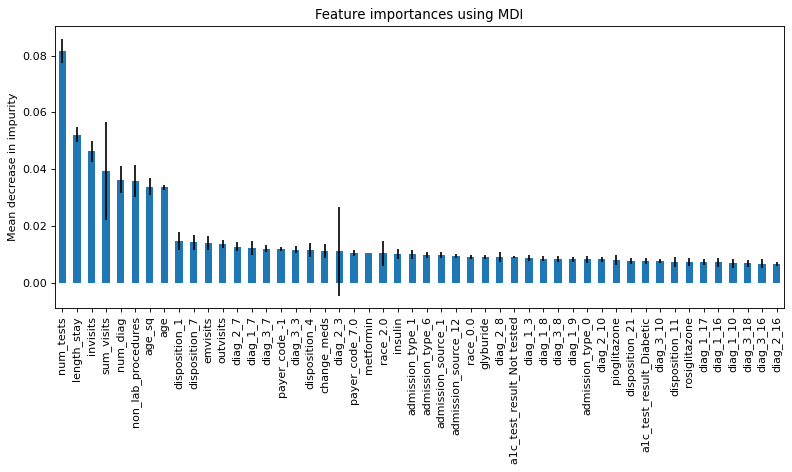

In [185]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(bootstrap=True, criterion='gini', min_samples_leaf=1, min_samples_split=23, n_estimators=278, random_state=42)

rf_classifier.fit(X_train, y_train)

feature_names = [i for i in X_train.columns]
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,6), dpi=80)
forest_importances.sort_values(ascending=False, inplace=True)
forest_importances.head(50).plot.bar(yerr=std[:50], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Print f1 score
y_pred = rf_classifier.predict(X_test)
print('F1 score: ', f1_score(y_test, y_pred))

In [186]:
# Lets try RFE to select the best features
from sklearn.feature_selection import RFE

rfe = RFE(rf_classifier, n_features_to_select=5, step=1, verbose=True)
rfe.fit(X_train, y_train)

# Print f1 score
y_pred = rfe.predict(X_test)
print('F1 score: ', f1_score(y_test, y_pred))

Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting est

In [187]:
# Get the most important features ranked in a dataframe
important_features = pd.DataFrame({'feature': X_train.columns, 'importance': rfe.ranking_})
important_features.sort_values(by='importance', inplace=True)
important_features

,feature,importance
22,age_sq,1
3,invisits,1
4,length_stay,1
5,num_tests,1
6,non_lab_procedures,1
...,...,...
98,disposition_5,108
53,diag_2_-1,109
56,diag_2_11,110
31,diag_3_11,111


In [188]:
X_ = X[important_features.head(25)['feature']]
#X_final_test_ = X_final_test[important_features.head(25)['feature']]

model = LogisticRegression(max_iter=10000)
kfold_model(model, X_, y, over=True)

Mean f1 score 0.257 +- 0.008


(0.25737938356529755, 0.007665666133203422)

In [189]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, f1_score

# Make an F1 scoring function
f1_scorer = make_scorer(f1_score, average='micro')

# The "estimator" is a classifier
estimator = LogisticRegression(max_iter=10000)

# The "step" parameter determines the amount of features to remove at each iteration
selector = RFECV(estimator, step=1, cv=5, scoring=f1_scorer, verbose=True, n_jobs=-1)
selector = selector.fit(X, y)

# The support mask shows which features are selected
#X_new = X[:, selector.support_]
mask = selector.support_
X_new = X.loc[:, mask]

Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting est

In [190]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define a range of hyperparameters to search
param_dist = {
    'n_estimators': randint(50, 1000),
    'max_depth': randint(2, 50),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 30),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=200, cv=5, n_jobs=-1, random_state=13, scoring='f1', verbose=1)

# Fit the RandomizedSearchCV object to your training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding F1 score
print("Best hyperparameters:", random_search.best_params_)

# Evaluate the model on the test data
best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)
print('F1: ', f1_score(y_test, y_pred))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [ ]:
models = [LogisticRegression(random_state=42, max_iter=1000), MLPClassifier(random_state=42, max_iter=1000), SVC(random_state=42), RandomForestClassifier(random_state=42), XGBClassifier(random_state=42), KNeighborsClassifier(), GaussianNB()]

for model in models:
    print(f'Fitting {model.__class__.__name__}')
    fit, score = test_model(model, X_train, y_train, X_test, y_test, just_score=True)
    print(f'Score for mode {model.__class__.__name__}: ', score)

In [ ]:
train.dtypes

In [ ]:
# Lets try neural networks with a MPLClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,5,5), activation='relu', max_iter=1000, random_state=42)
fit = test_model(mlp, X_train, y_train, X_test, y_test)

In [ ]:
xgb = XGBClassifier(random_state=42)
fit = test_model(xgb, X_train, y_train, X_test, y_test)

###___Kfold cross validation___

In [ ]:
models = [LogisticRegression(random_state=42, max_iter=5000), MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(4,4,4), activation='logistic'), SVC(random_state=42), RandomForestClassifier(random_state=42), XGBClassifier(random_state=42), KNeighborsClassifier(), GaussianNB()]


# Use kfold-10 cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
undersampler = RandomUnderSampler(random_state=42)
underScores = pd.DataFrame()

i = 0
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_fold, y_train_fold)

    temp_under, temp_over = {}, {}
    for model in models:
        print(f'Fitting {model.__class__.__name__}', i)
        fit = model.fit(X_train_undersampled, y_train_undersampled)
        y_pred = fit.predict(X_test_fold)
        score = f1_score(y_test_fold, y_pred)
        temp_under[model.__class__.__name__] = score

    temp_under = pd.DataFrame(temp_under, index=[i])
    underScores = pd.concat([underScores, temp_under], axis=0)
    i += 1

In [ ]:
underScores.max().sort_values(ascending=False)

##__Predictions___

In [ ]:
train.info()

In [ ]:
train["race"].value_counts()

In [ ]:
X.isna()

In [ ]:
X = train[train['readmitted_binary'].notna()]

In [ ]:
X.isna().sum()